## **Overview**

In this notebook, we are comparing a traditional **linear regression model (OLS)** with a **Bayesian linear regression model (BLR)** and **logistic regression model** with a **Bayesian logistic regression model**. The goal is to understand how Bayesian modeling differs in concept, computation, and interpretation compared to classical methods.

We first study the concept of Bayesian Linear Regression and its mathematical formulation. Then, we apply both models step-by-step on a real-world air quality dataset.
Perfect, Dewa! Since you're using **Air Quality** for **regression** (continuous target) and **Diabetes dataset** for **classification**, here's your **updated modeling pipeline** split clearly into two parts: **Regression** and **Classification**.

## **Notebook Pipeline**

### Part A: Regression Modeling using **Air Quality Dataset**

1. **Load and Clean Data**

   * Import the air quality dataset (e.g., PM2.5 levels).
   * Handle missing values using mean imputation or advanced cleaning.
   * Understand the data using `.info()`, `.describe()`, and visual plots.

2. **Feature Selection + Engineering**

   * Select top features that show highest correlation with PM2.5.
   * Engineer interaction terms based on domain knowledge:

     * TEMP × PRES
     * O3 × TEMP
     * NO2 × CO
   * Normalize/scale the data if needed.

3. **Apply OLS (Ordinary Least Squares)**

   * Fit classical linear regression:

     * $\hat{y} = X\beta$
   * Evaluate using:

     * Mean Squared Error (MSE)
     * Coefficient of Determination (R²)

4. **Apply Bayesian Linear Regression (BLR)**

   * Use the analytical posterior:

     * $\mu_{\text{post}} = (X^TX + \lambda I)^{-1}X^Ty$
     * $\Sigma_{\text{post}} = (X^TX + \lambda I)^{-1}$
   * Sample from posterior to create predictive intervals.
   * Visualize uncertainty in prediction (e.g., shaded confidence band around predicted PM2.5).

---

###  Part B: Classification Modeling using **Pima Indians Diabetes Dataset**

5. **Load and Clean Data**

   * Import the `diabetes.csv` dataset.
   * Handle missing values using `mean` imputation (e.g., for Glucose, BMI).
   * Define input features (`X`) and binary target (`Outcome`).

6. **Apply Logistic Regression**

   * Fit standard logistic regression:

     * $\text{logit}(p) = Xw$
     * $p = \frac{1}{1 + e^{-Xw}}$
   * Evaluate using:

     * Accuracy
     * Log Loss
     * Precision/Recall if needed
   * Plot decision boundary if you reduce to 2D.

7. **Apply Bayesian Logistic Regression (BLR-classification)**

   * Define log-posterior: likelihood + Gaussian prior on weights.
   * Use **BFGS optimizer** to find MAP estimate.
   * Approximate posterior as:

     * $w \sim \mathcal{N}(w_{MAP}, \Sigma)$
   * Sample from posterior to generate:

     * Predictive probabilities (uncertainty-aware)
     * Confidence intervals for class predictions
   * Evaluate again with:

     * Accuracy
     * Log Loss
     * Optional: ROC-AUC or uncertainty histograms


#### **When Are They Equivalent?**
If prior is weak ($\tau^2 \rightarrow \infty$) or dataset is large:

* BLR posterior mean $\mu_{post} \rightarrow \hat{\beta}_{OLS}$
* BLR predictions become same as OLS

----

### Step 1: ***Loading and cleaning dataset***



- Load the `Air_Quality_Data_Dingling.csv` dataset using a custom `clean_data()` function with mean imputation to handle missing values.
- Display the first few rows and basic dataset info (`.head()`, `.info()`) for initial inspection.
- Drop irrelevant columns like `No` and `station`, which do not contribute meaningful information to the model.
- Convert the categorical wind direction column (`wd`) into numerical format using one-hot encoding (`get_dummies`), and remove one dummy to avoid multicollinearity.
- Convert all boolean-type columns to integers for compatibility with numerical modeling.


In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from cleaning_module  import  *
from all_model import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from scipy.stats import multivariate_normal, bernoulli


data_name = 'Air_Quality_Data_Dingling.csv'
data = clean_data(data_name, method= 'fill_mean' )
print('-------------------------------------------------------------------')
print(data.head(5))
print('\n-------------------------------------------------------------------\n')

print(data.info())

# Dropping Station column from dataset because it is not useful in data
data = data.drop(columns=['No', 'station'])

# changing categorical column to numerical column
data = pd.get_dummies(data, columns=['wd'], drop_first= True)
bool_col = data.select_dtypes(include='bool').columns
data[bool_col] = data[bool_col].astype(int)
print('\n-------------------------------------------------------------------\n')

print(data.info())

print('\n------------------------------------------------------------------\n')
print(data.columns)

Data loaded successfully.
Duplicates removed: 0
Missing values filled with mean.
Cleaned data saved to cleaned_data.csv
No           0
year         0
month        0
day          0
hour         0
PM2.5        0
PM10         0
SO2          0
NO2          0
CO           0
O3           0
TEMP         0
PRES         0
DEWP         0
RAIN         0
wd         140
WSPM         0
station      0
dtype: int64
-------------------------------------------------------------------
   No  year  month  day  hour  PM2.5  PM10  SO2        NO2     CO    O3  TEMP  \
0   1  2013      3    1     0    4.0   4.0  3.0  27.585467  200.0  82.0  -2.3   
1   2  2013      3    1     1    7.0   7.0  3.0  27.585467  200.0  80.0  -2.5   
2   3  2013      3    1     2    5.0   5.0  3.0   2.000000  200.0  79.0  -3.0   
3   4  2013      3    1     3    6.0   6.0  3.0  27.585467  200.0  79.0  -3.6   
4   5  2013      3    1     4    5.0   5.0  3.0  27.585467  200.0  81.0  -3.5   

     PRES  DEWP  RAIN   wd  WSPM   station

## ***Feature Selection + Engineering and Train-Test Split***


- **Base Features**: Start with core pollutant features (`PM10`, `SO2`, `NO2`, `CO`) which are known contributors to air quality degradation.
  
- **Interaction Features**: Add domain-informed interaction terms to capture nonlinear relationships:
  - `PRES × TEMP` – pressure-temperature interaction
  - `DEWP × PRES` – dew point and pressure interaction
  - `TEMP × DEWP` – temperature and humidity interaction
  - `O3 × PRES`, `TEMP × O3` – ozone’s interaction with pressure and temperature
  
- **Target Variable**: Set `PM2.5` as the target variable for regression.

- **Visualization**: Use a custom `data_plot()` function to visualize the relationship between features and target variable.

- **Train-Test Split**: Split the data into training and testing sets (80-20) using `train_test_split()` and append a bias term (column of ones) to both sets for intercept modeling.


Index(['year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO',
       'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM', 'wd_ENE', 'wd_ESE',
       'wd_N', 'wd_NE', 'wd_NNE', 'wd_NNW', 'wd_NW', 'wd_S', 'wd_SE', 'wd_SSE',
       'wd_SSW', 'wd_SW', 'wd_W', 'wd_WNW', 'wd_WSW'],
      dtype='object')
 Skewness & Kurtosis of features:
PM10                 | Skew: 2.12 | Kurtosis: 8.28


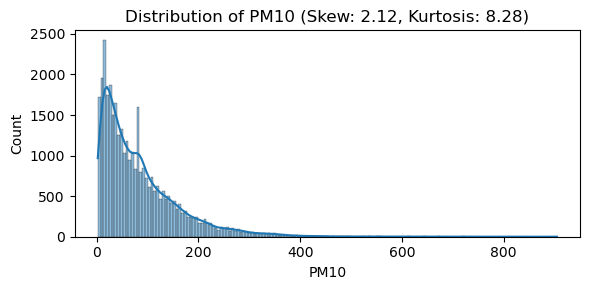

SO2                  | Skew: 2.80 | Kurtosis: 10.36


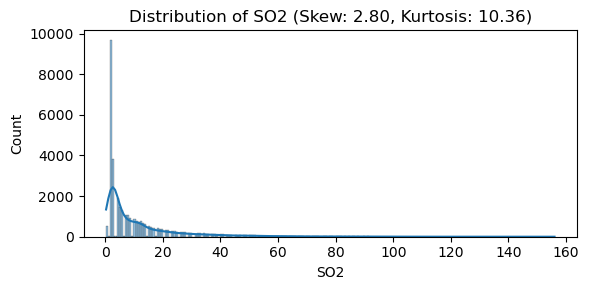

NO2                  | Skew: 1.73 | Kurtosis: 3.67


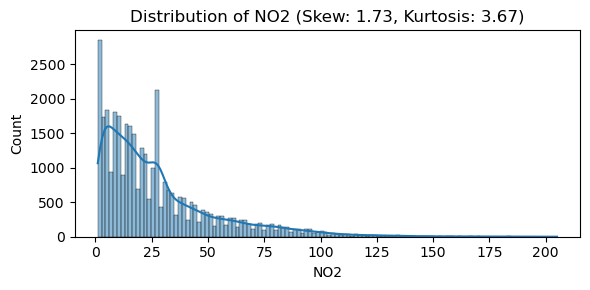

CO                   | Skew: 2.89 | Kurtosis: 13.62


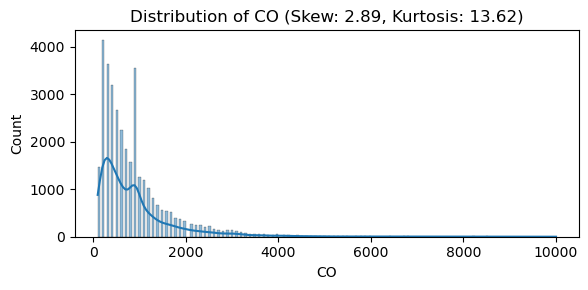

PRES*TEMP            | Skew: -0.12 | Kurtosis: -1.12


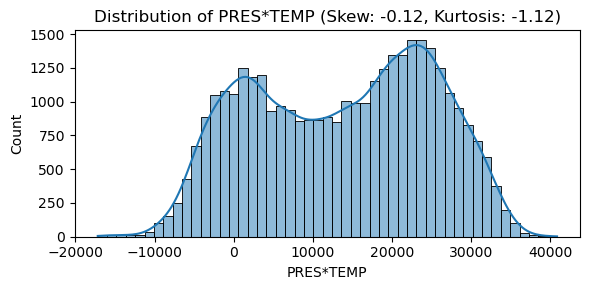

DEWP*PRESS           | Skew: -0.17 | Kurtosis: -1.16


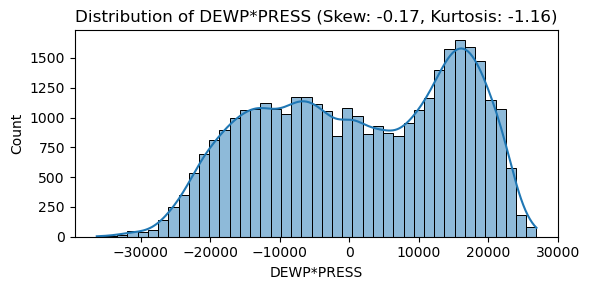

TEMP*DEWP            | Skew: 0.70 | Kurtosis: -0.37


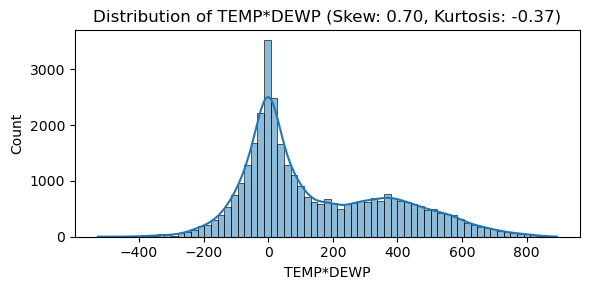

O3*PRES              | Skew: 1.53 | Kurtosis: 3.98


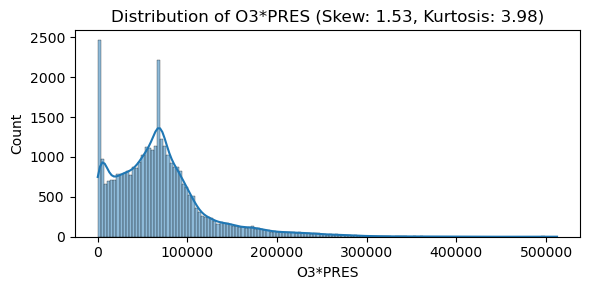

TEMP*O3              | Skew: 2.16 | Kurtosis: 5.96


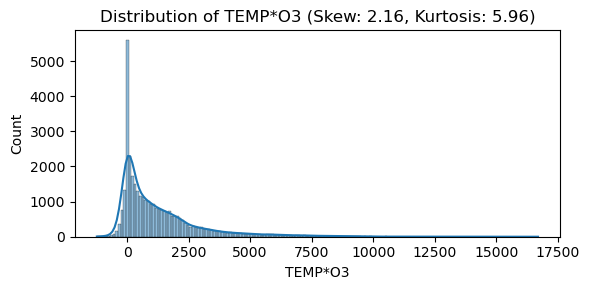


 Relationship with Target (charges):


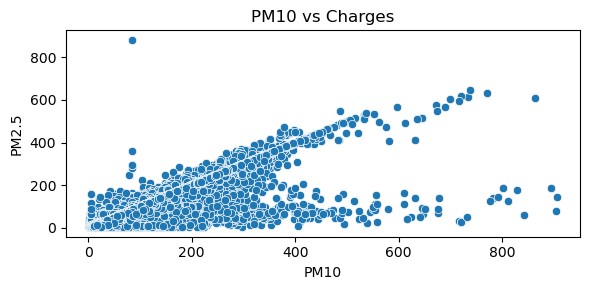

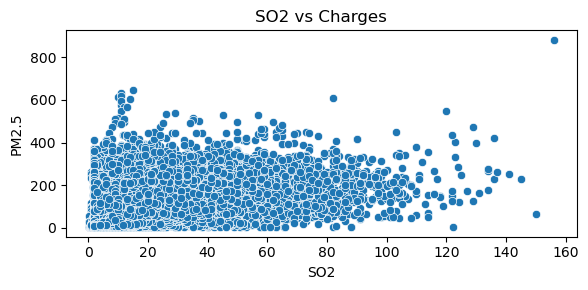

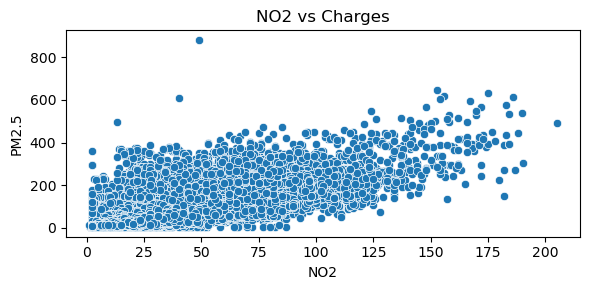

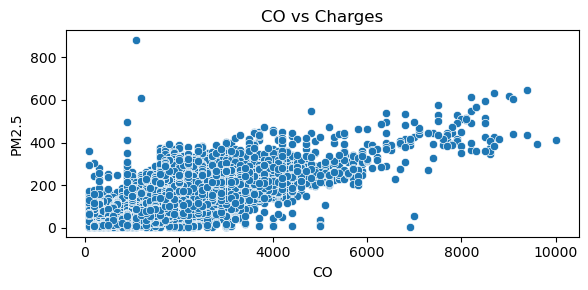

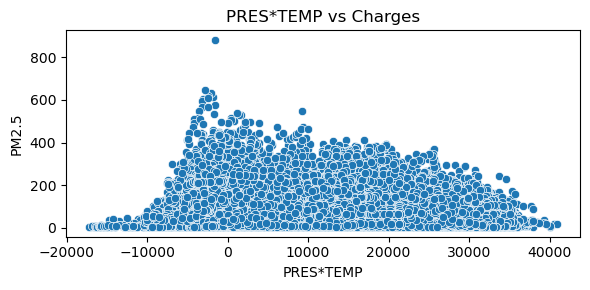

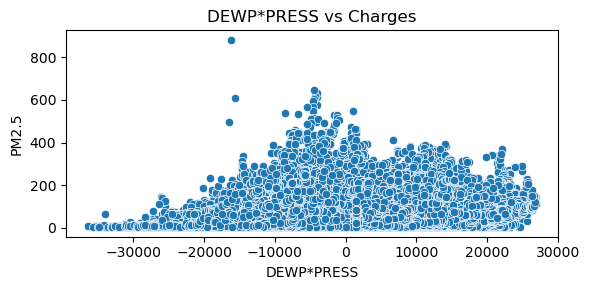

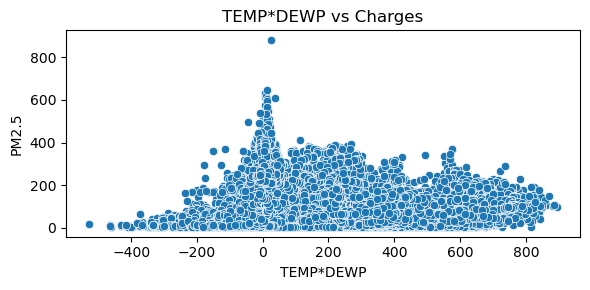

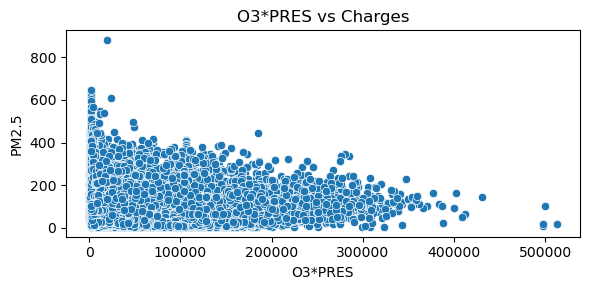

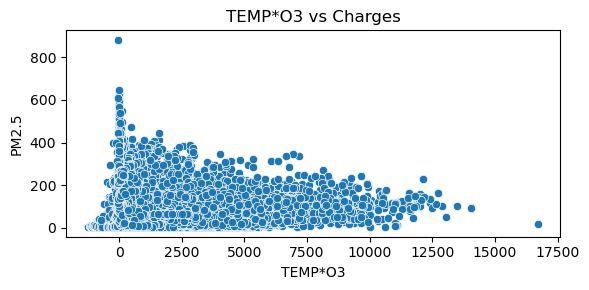

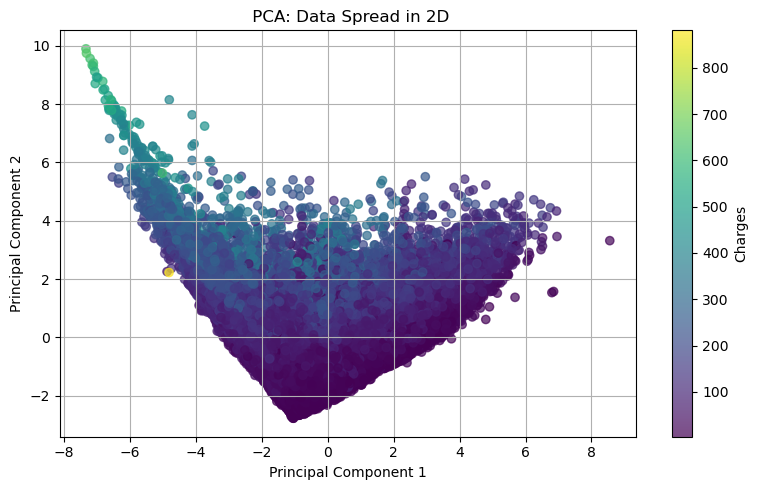

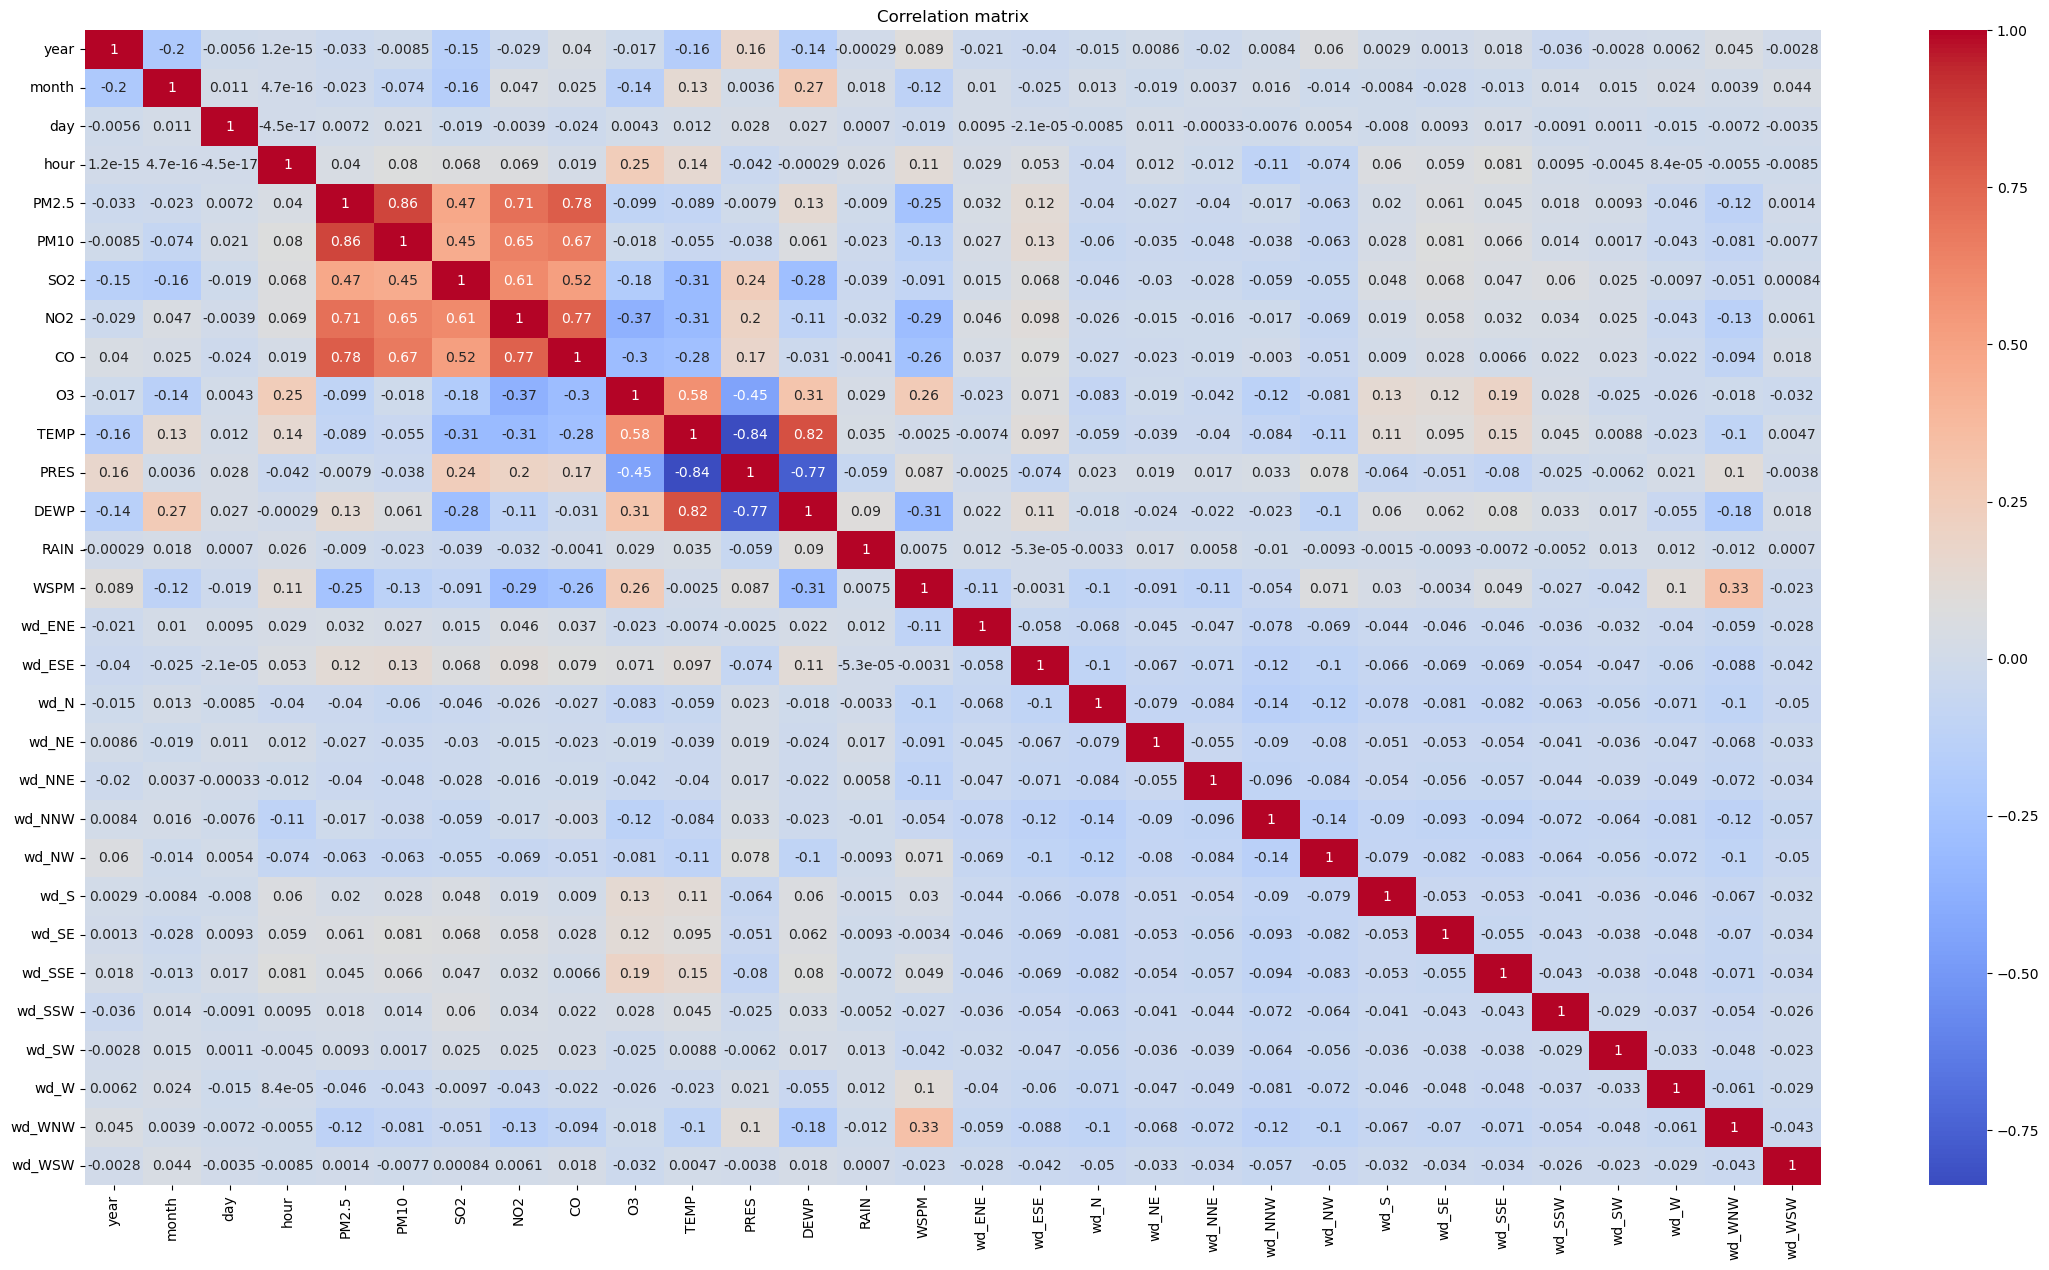

In [23]:
print(data.columns)
# Step 1: Base features
X_base = data[['PM10', 'SO2', 'NO2', 'CO']]

# Step 2: Create new interaction features
x1 = data['PRES'] * data['TEMP']
x2 = data['DEWP'] * data['PRES']
x3 = data['TEMP'] * data['DEWP']
x4 = data['O3'] * data['PRES']
x5 = data['TEMP'] * data['O3']
# x6 = data['CO'] * data['CO']
# x7 = data['PM10'] * data['PM10']
# x8 = data['NO2'] * data['NO2']



# Step 3: Add new features into DataFrame
X = X_base.copy()
X['PRES*TEMP'] = x1
X['DEWP*PRESS'] = x2
X['TEMP*DEWP'] = x3
X['O3*PRES'] = x4
X['TEMP*O3'] = x5
# X['CO*CO'] = x6
# X['PM10*PM10'] = x7
# X['NO2*NO2'] = x8

# Step 4: Target
y = data['PM2.5']

# relational plot between features and target variables
data_plot(data, X, y)




X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
X_test = np.hstack([np.ones((X_test.shape[0], 1)), X_test])


## **Ordinary Least Squares (OLS)**

### Goal

OLS aims to find a single best-fit line by minimizing the sum of squared differences between predicted and actual target values.

### Model

Let:

* $X \in \mathbb{R}^{n \times d}$: Feature matrix (with bias term if needed)
* $y \in \mathbb{R}^{n}$: Target vector
* $\beta \in \mathbb{R}^{d}$: Weight vector

OLS minimizes the cost function:
$J(\beta) = \| y - X\beta \|^2$

### Solution

The optimal weights are given by:
$\hat{\beta}_{OLS} = (X^T X)^{-1} X^T y$

### Prediction

$\hat{y} = X \hat{\beta}_{OLS}$

## **OLS Results**

| Metric             | Training Set | Test Set   |
|--------------------|--------------|------------|
| R² (R-square)      | 0.8449       | 0.8605     |
| MSE (Mean Squared Error) | 796.5411     | 695.7522   |



-----OLS Results-------
Trainning results : 

Traning R_square : 0.8449
Traning MSE : 796.5411


Test results: 

Test R_square : 0.8605
Test MSE : 695.7522


----Training plot-----


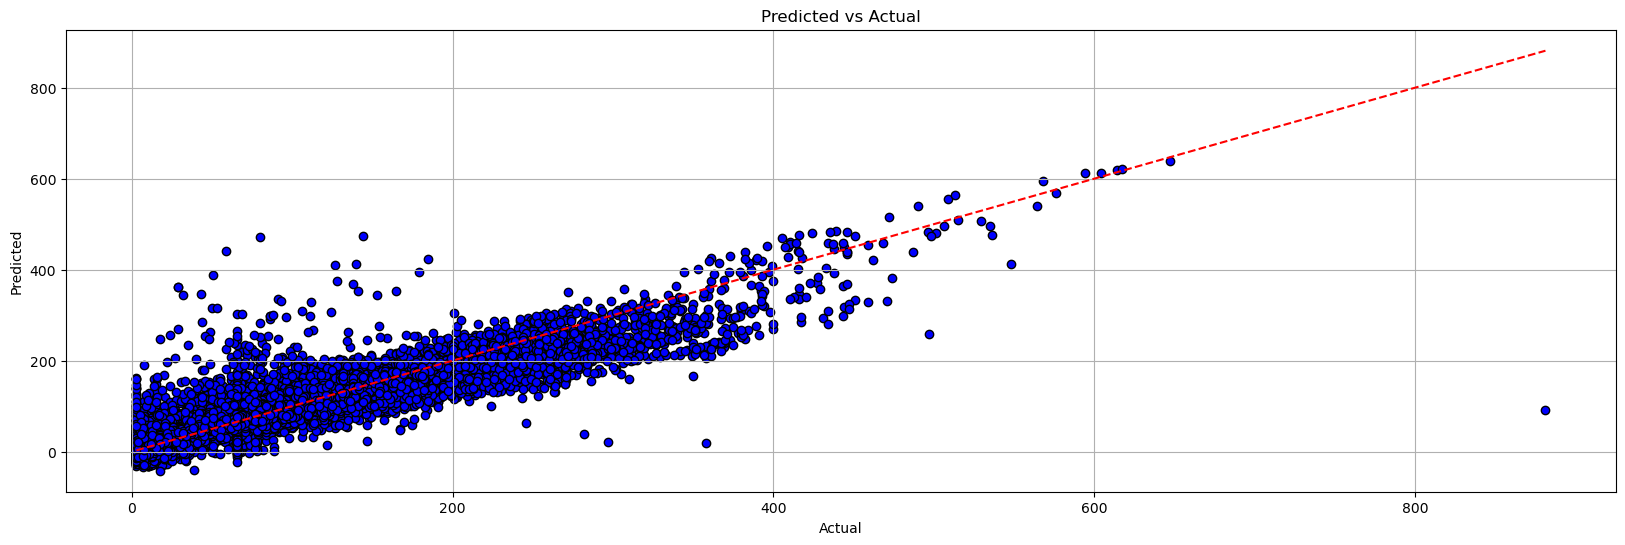

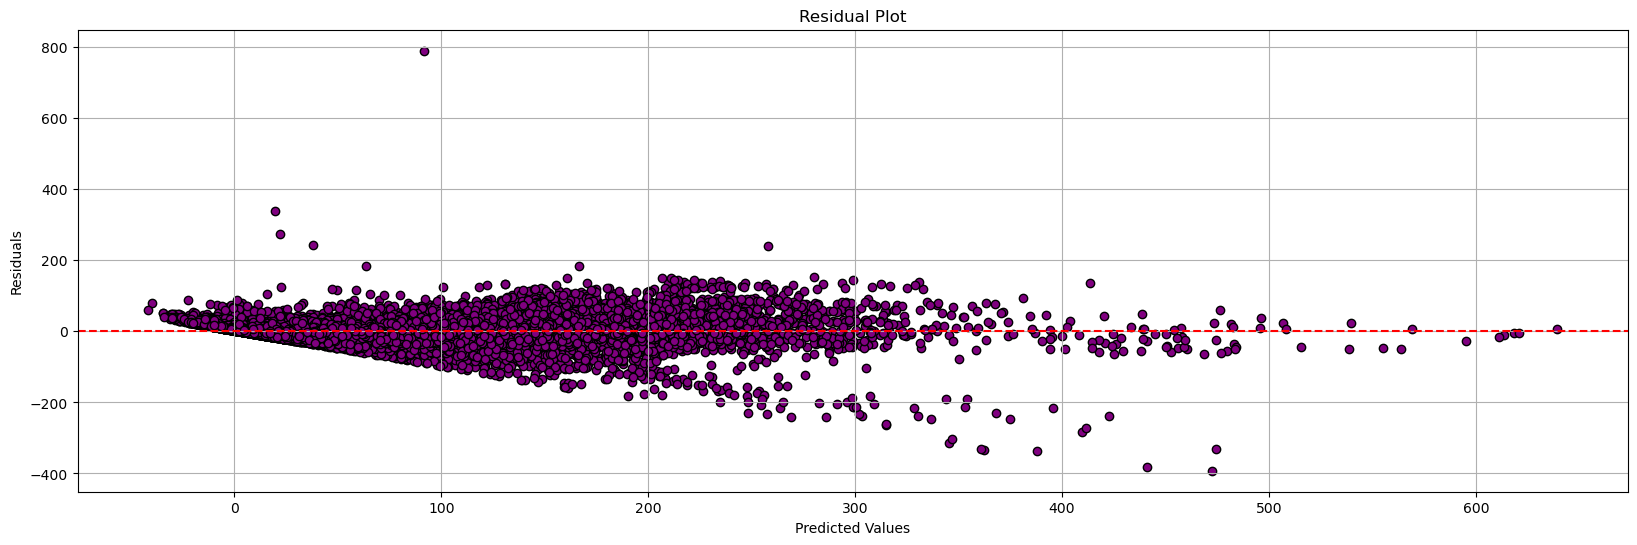

----Test Plot-------


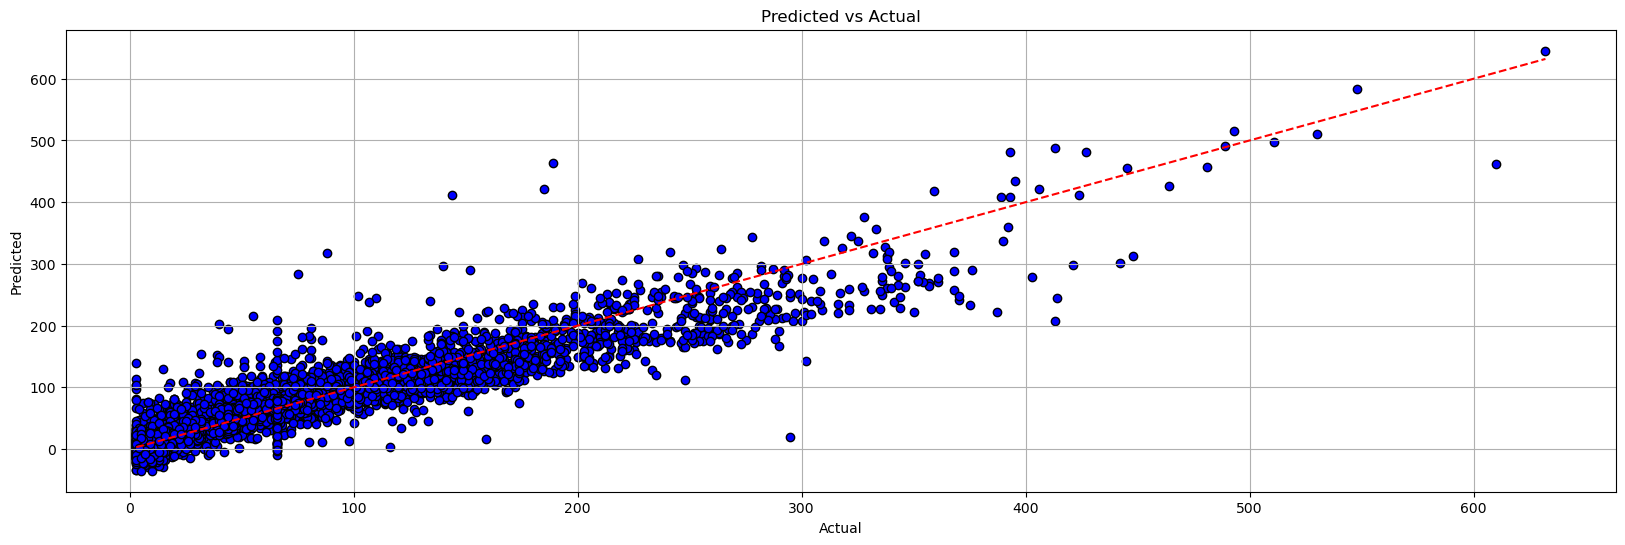

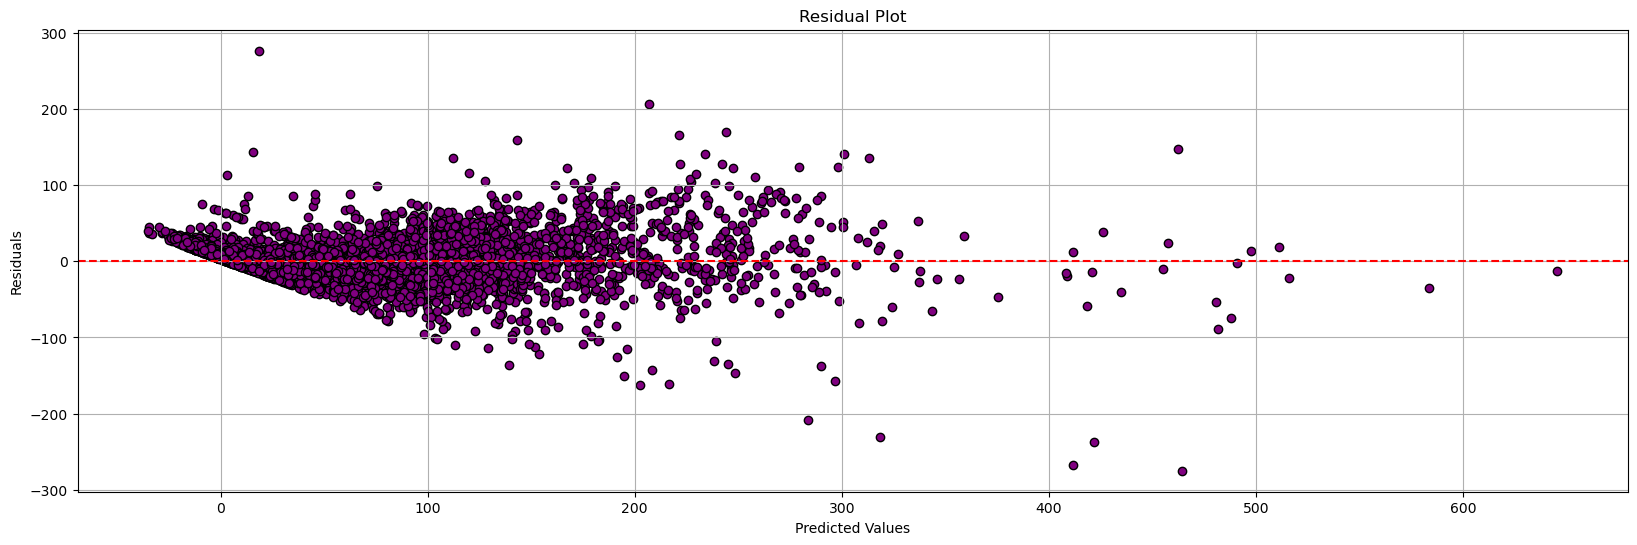

In [24]:

#Ordinary Least Square Method

beta = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train
y_train_pred_OLS = X_train @ beta

y_test_pred_OLS = X_test @ beta

train_r2 = r2_score(y_train, y_train_pred_OLS)
test_r2 = r2_score(y_test, y_test_pred_OLS)

train_mse = mean_squared_error(y_train, y_train_pred_OLS)
test_mse = mean_squared_error(y_test, y_test_pred_OLS)

print('-----OLS Results-------')

print('Trainning results : \n')
print(f"Traning R_square : {train_r2:.4f}")
print(f"Traning MSE : {train_mse:.4f}")


print('\n\nTest results: \n')
print(f"Test R_square : {test_r2:.4f}")
print(f"Test MSE : {test_mse:.4f}")

print('\n\n----Training plot-----')
plot(y_train, y_train_pred_OLS)

print('----Test Plot-------')
plot(y_test, y_test_pred_OLS)


## **Bayesian Linear Regression (BLR)**

###  Goal

Bayesian Linear Regression (BLR) models a **distribution over weights** instead of estimating a single weight vector. It captures **uncertainty** in both model parameters and predictions.  
Unlike OLS, which provides only point predictions, BLR offers **confidence intervals** by propagating uncertainty from the weights to the outputs.

---

###  Prior Assumptions

- **Prior on weights**:  
  $$ p(w) = \mathcal{N}(0, \tau^2 I) $$
- **Likelihood**:  
  $$ p(y | X, w) = \mathcal{N}(Xw, \sigma^2 I) $$

Here,  
- $\tau^2$ = prior variance  
- $\sigma^2$ = observation noise

---

###  Posterior Distribution

Using Bayes' theorem:

$$
p(w | X, y) \propto p(y | X, w) \cdot p(w)
$$

This gives a **Gaussian posterior**:

$$
\Sigma_{post} = \left( \frac{1}{\sigma^2} X^T X + \frac{1}{\tau^2} I \right)^{-1}
$$

$$
\mu_{post} = \Sigma_{post} \left( \frac{1}{\sigma^2} X^T y \right)
$$

---

###  Prediction: Posterior Predictive Distribution

For a new point $x^*$, the **posterior predictive** distribution is:

- **Mean**:  
  $$ \mathbb{E}[y^*] = x^{*T} \mu_{post} $$
- **Variance**:  
  $$ \text{Var}(y^*) = \sigma^2 + x^{*T} \Sigma_{post} x^* $$

---




#### 2. **Distribution of Predicted Values**

Use histogram + KDE to visualize the model’s output on:
- **Train set** and **Test set** (BLR predicted means)
- This gives intuition into how model beliefs spread

---

### BLR Results

| Metric                   | Training Set | Test Set   |
|--------------------------|--------------|------------|
| R² (R-squared)           | *0.8449*   | *0.8605* |
| MSE (Mean Squared Error) | *796.5411*   | *695.7523* |






---BLR Results-----

 Train results: 

Train MSE: 796.5411
Train R²: 0.8449

 Test results: 

Test MSE: 695.7521
Test R²: 0.8605


----Training plot-----


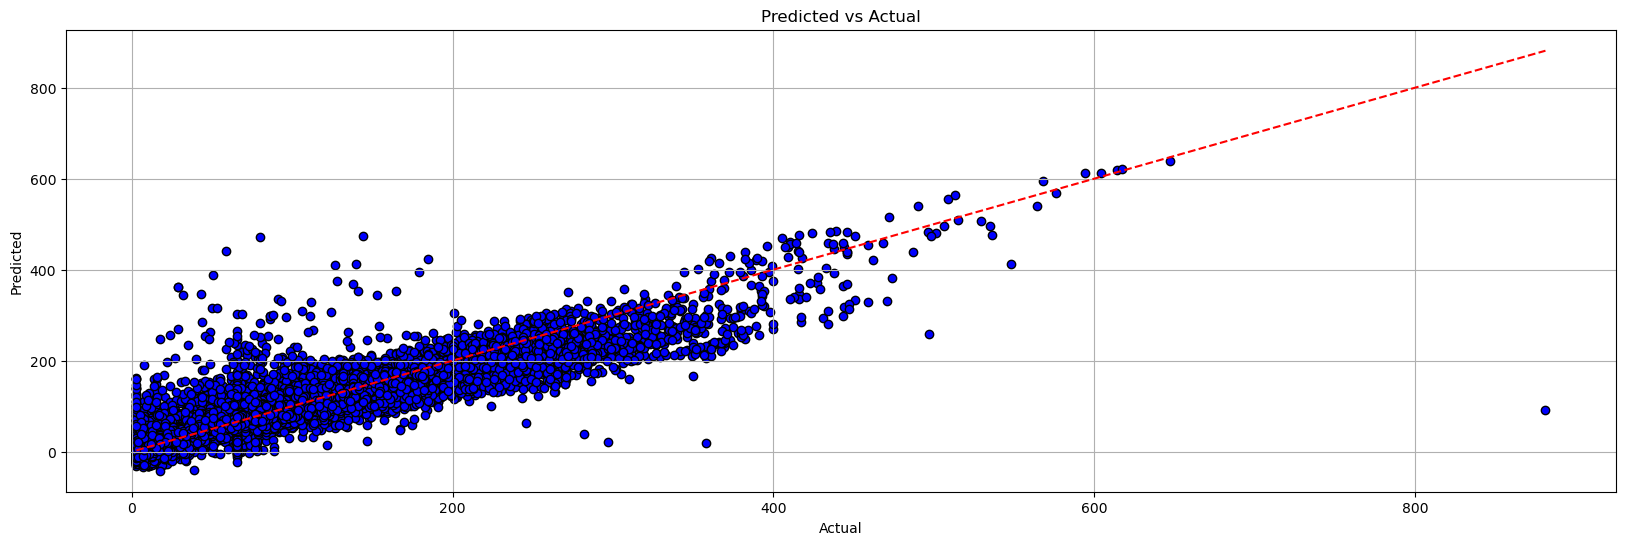

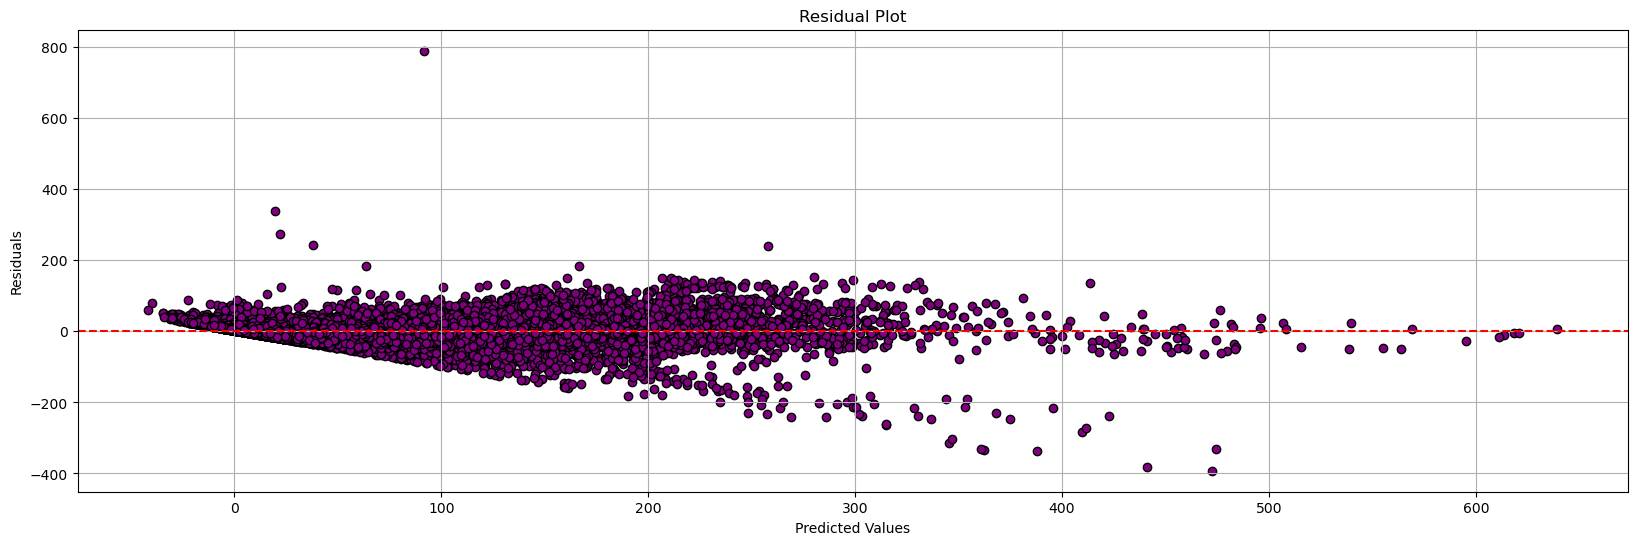

----Test Plot-------


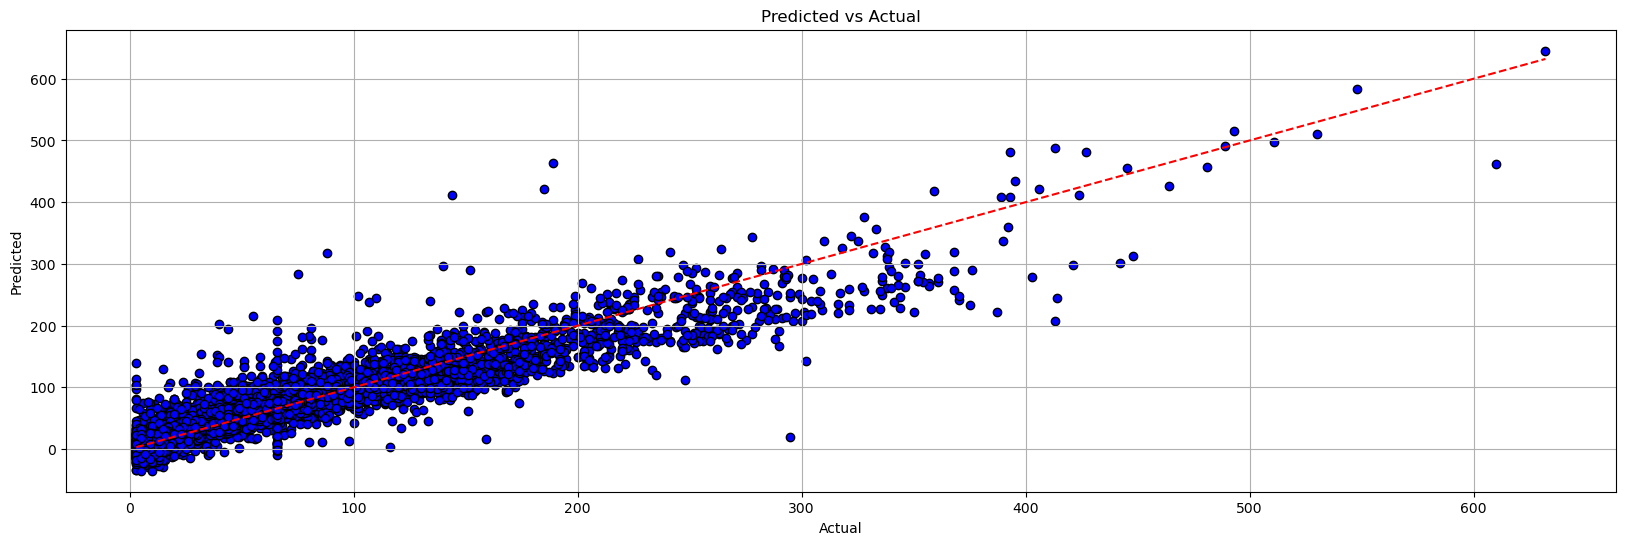

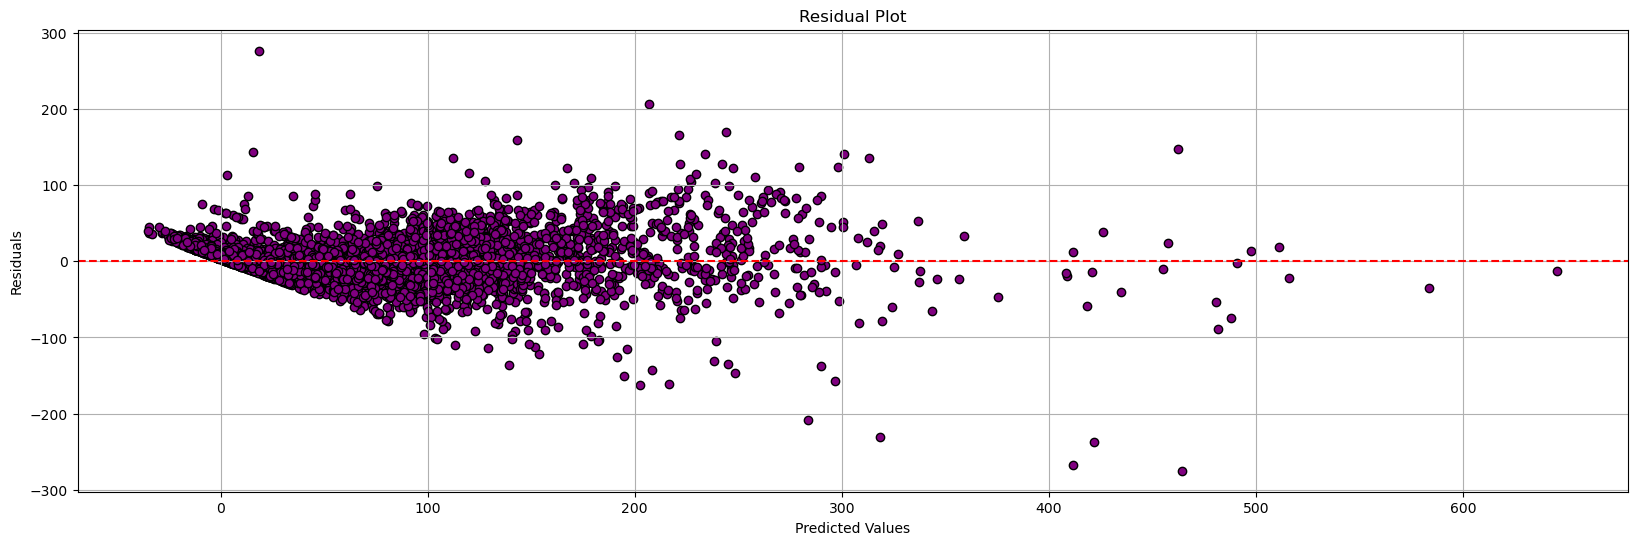

In [25]:

# prior Variance and noise variance
sigma2 = 0.01
tau2 = 1  

def baysian_linear(sigma2_pre, tau2_pre, X_train, y_train):

    I = np.eye(X_train.shape[1])
    Sigma_post = np.linalg.inv((1/sigma2_pre) * X_train.T @ X_train + (1/tau2_pre) * I)
    mu_post = (1/sigma2_pre) * Sigma_post @ X_train.T @ y_train
    
    return Sigma_post, mu_post    

Sigma_post, mu_post = baysian_linear(sigma2, tau2, X_train, y_train)


n_samples = 500
w_samples = np.random.multivariate_normal(mu_post.ravel(), Sigma_post, size=n_samples)  # shape: (n_samples, d)

# Predict using each sampled w
y_train_pred = np.array([X_train @ w for w in w_samples])  # shape: (n_samples, n_test)
y_test_pred = np.array([X_test @ w for w in w_samples])  # shape: (n_samples, n_test)



# Mean prediction across samples
y_train_pred_mean = y_train_pred.mean(axis=0)
y_test_pred_mean = y_test_pred.mean(axis=0)


# Uncertainty (standard deviation)
y_train_pred_std = y_train_pred.std(axis=0)
y_test_pred_std = y_test_pred.std(axis=0)

print('---BLR Results-----')
print('\n Train results: \n')
print(f"Train MSE: {mean_squared_error(y_train, y_train_pred_mean):.4f}")
print(f"Train R²: {r2_score(y_train, y_train_pred_mean):.4f}")



print('\n Test results: \n')
print(f"Test MSE: {mean_squared_error(y_test, y_test_pred_mean):.4f}")
print(f"Test R²: {r2_score(y_test, y_test_pred_mean):.4f}")

# Plotting section

print('\n\n----Training plot-----')
plot(y_train, y_train_pred_mean)

print('----Test Plot-------')
plot(y_test, y_test_pred_mean)


## dataset is very big so taking subset of test data for testing and visualisation 

# Sample 100 random test points
sample_idx = np.random.choice(len(X_test), size=100, replace=False)
X_sample = X_test[sample_idx]
y_sample = y_test.iloc[sample_idx]

# Recompute predictive mean and std on sample
y_sample_pred = X_sample @ mu_post
y_sample_std = np.sqrt(np.array([sigma2 + x.T @ Sigma_post @ x for x in X_sample]))


### Visualizations

#### 1. **BLR Prediction with Uncertainty (Error Bars)**

To better visualize model confidence:
- Take a random subset of 100 test samples.
- For each, compute:
  - Predictive mean
  - Predictive standard deviation
- Plot using `plt.errorbar()`:
  - **Dots**: Predicted mean
  - **Vertical bars**: ± standard deviation (uncertainty)
  - **Red line**: True target values

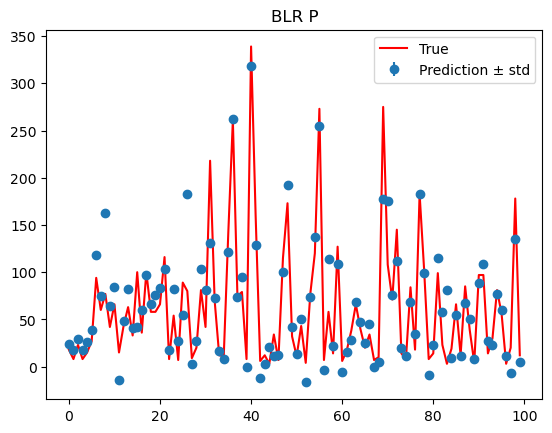

In [26]:
# Plot: BLR Prediction vs True (with Uncertainty)
plt.errorbar(range(len(y_sample)), y_sample_pred, yerr=y_sample_std, fmt='o', label='Prediction ± std')
plt.plot(range(len(y_sample)), y_sample.values, 'r-', label='True')
plt.legend()
plt.title("BLR P")
plt.show()


### Predicted Output Distribution – BLR

This plot shows the distribution of **mean predictions** from Bayesian Linear Regression on both train and test sets:

- **Blue (Train)** and **Orange (Test)**: Predicted output distributions
- **Red Line at 0**: Reference point for interpretation
- **KDE + Histogram**: Visualizes how confident and spread out the predictions are

Useful to compare model behavior on seen vs unseen data and check for generalization.


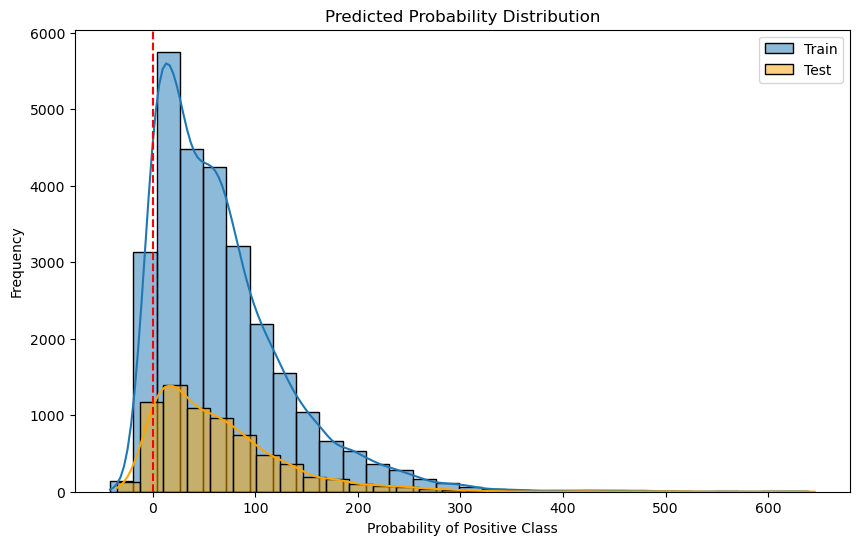

In [27]:
plt.figure(figsize=(10, 6))
sns.histplot(y_train_pred_mean, bins=30, kde=True, label='Train')
sns.histplot(y_test_pred_mean, bins=30, kde=True, label='Test', color='orange')
plt.axvline(0.5, color='red', linestyle='--')
plt.title('Predicted Probability Distribution')
plt.xlabel('Probability of Positive Class')
plt.ylabel('Frequency')
plt.legend()
plt.show()


## Comparison: OLS vs BLR

| Aspect               | OLS                        | BLR                                 |        |
| -------------------- | -------------------------- | ----------------------------------- | ------ |
| Output               | Point estimate ($\hat{w}$) | Distribution over weights ( p(w     | X,y) ) |
| Regularization       | None                       | Implicit via prior                  |        |
| Uncertainty Estimate | No                         | Yes (posterior predictive variance) |        |
| Sensitivity to Data  | High                       | Controlled by prior strength        |        |
| Uses Prior           | No                         | Yes                                 |        |


# **Simple Logistic Regression vs Bayesian Logistic Regression**


###  **Data Loading & Preprocessing – *Breast Cancer***

- Import the `load_breast_cancer.csv` dataset from sklearn.dataset and handle missing values using mean imputation (`fill_mean` method).
- Display initial structure and info of the dataset for validation and inspection.
- Select relevant features except `Outcome` as input variables.
- Set `Outcome` (0 or 1) as the binary classification target.
- Visualize relationships between features and the target using `data_plot()`.
- Split the data into training and testing sets (80-20 split).
- Add a bias term (intercept column of ones) to both train and test feature matrices.



-------------------------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error

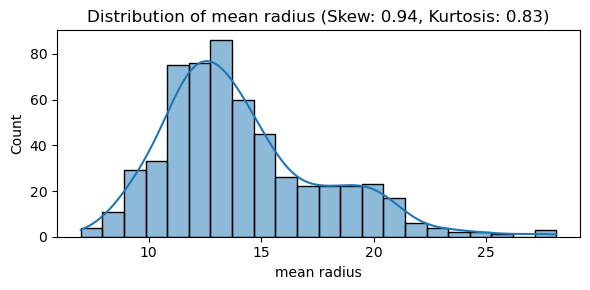

mean texture         | Skew: 0.65 | Kurtosis: 0.74


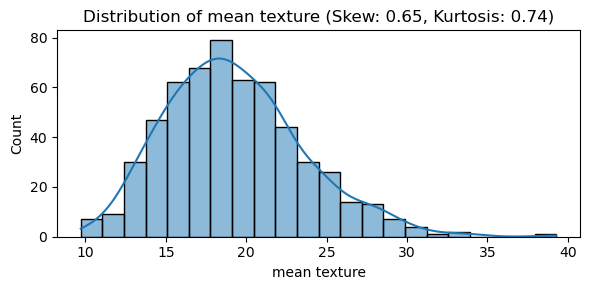

mean perimeter       | Skew: 0.99 | Kurtosis: 0.95


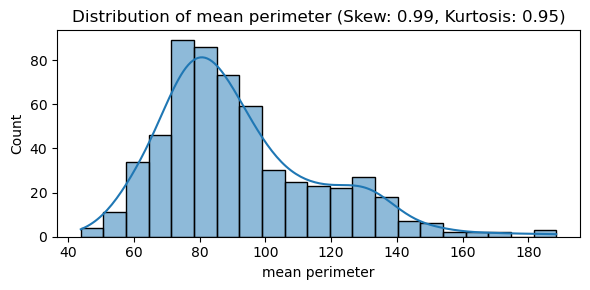

mean area            | Skew: 1.64 | Kurtosis: 3.61


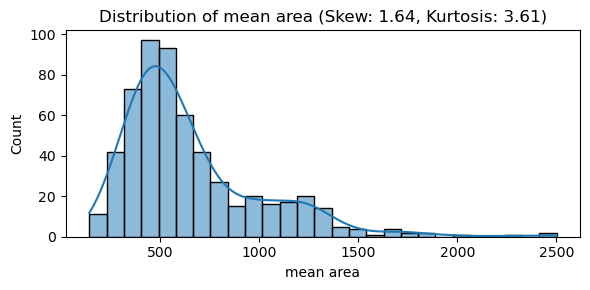

mean smoothness      | Skew: 0.46 | Kurtosis: 0.84


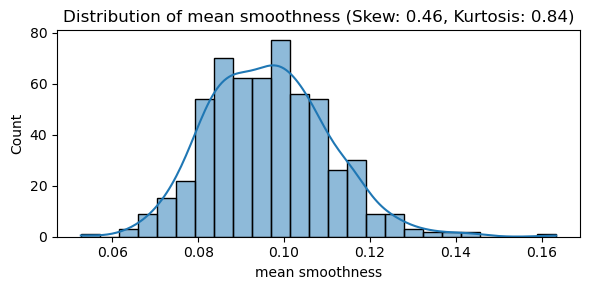

mean compactness     | Skew: 1.19 | Kurtosis: 1.63


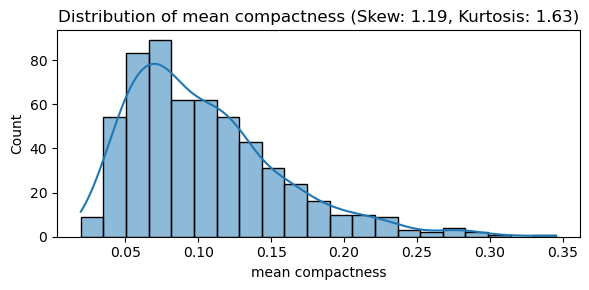

mean concavity       | Skew: 1.40 | Kurtosis: 1.97


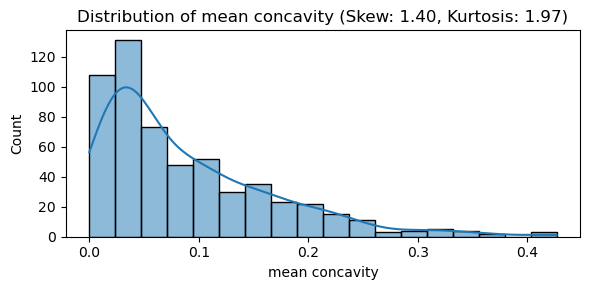

mean concave points  | Skew: 1.17 | Kurtosis: 1.05


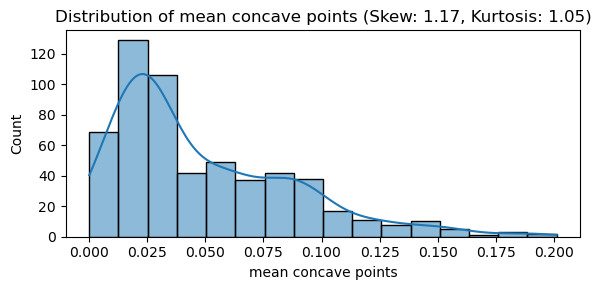

mean symmetry        | Skew: 0.72 | Kurtosis: 1.27


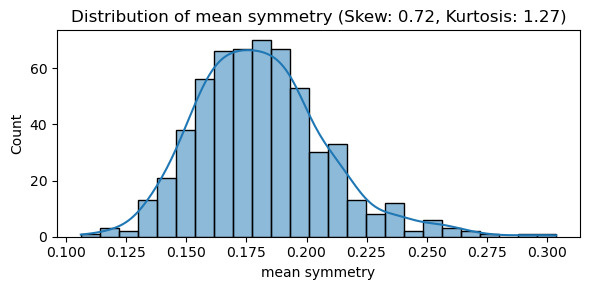

mean fractal dimension | Skew: 1.30 | Kurtosis: 2.97


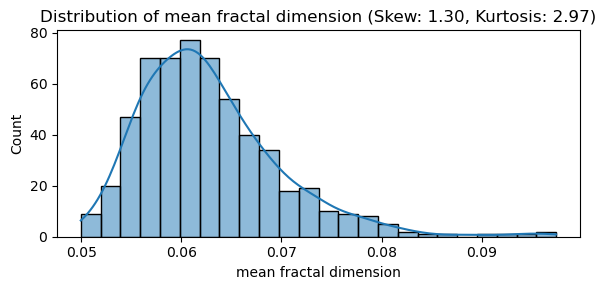

radius error         | Skew: 3.08 | Kurtosis: 17.52


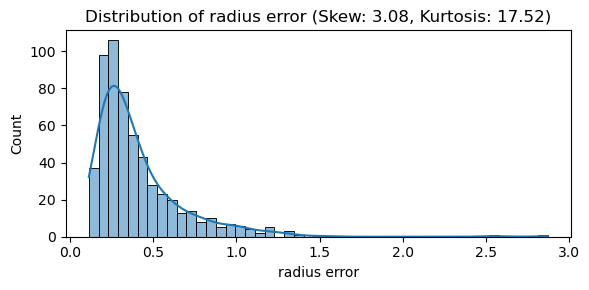

texture error        | Skew: 1.64 | Kurtosis: 5.29


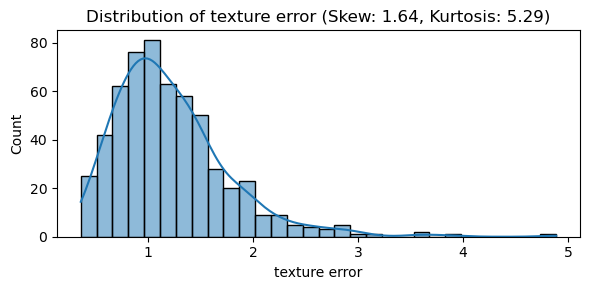

perimeter error      | Skew: 3.43 | Kurtosis: 21.20


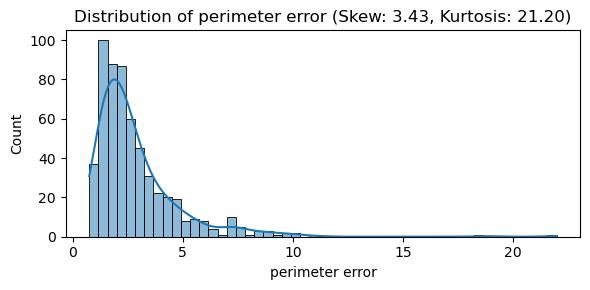

area error           | Skew: 5.43 | Kurtosis: 48.77


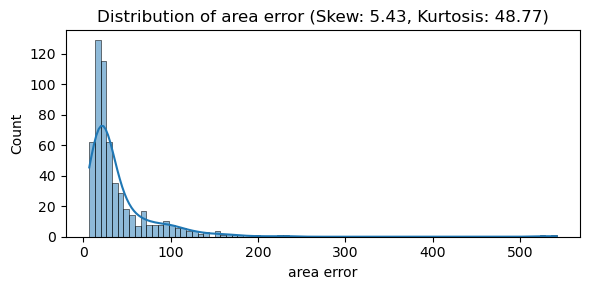

smoothness error     | Skew: 2.31 | Kurtosis: 10.37


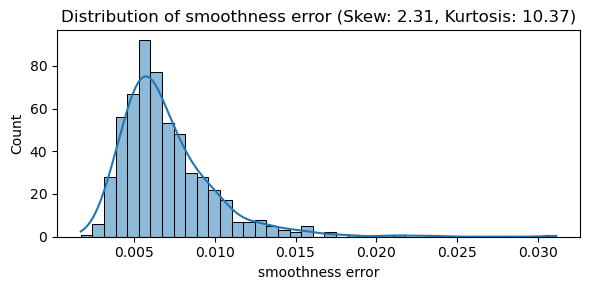

compactness error    | Skew: 1.90 | Kurtosis: 5.05


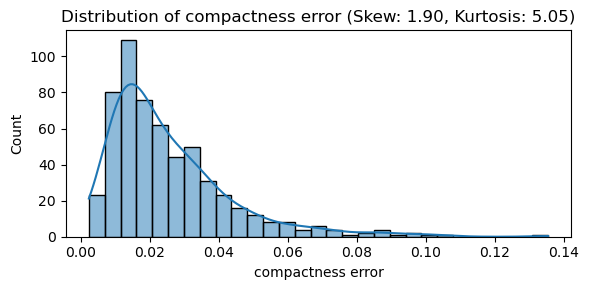

concavity error      | Skew: 5.10 | Kurtosis: 48.42


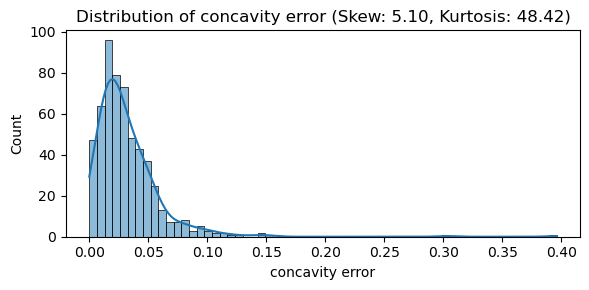

concave points error | Skew: 1.44 | Kurtosis: 5.07


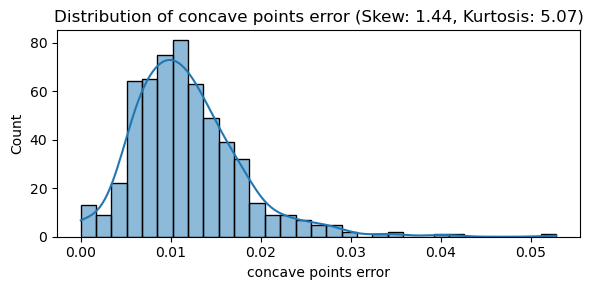

symmetry error       | Skew: 2.19 | Kurtosis: 7.82


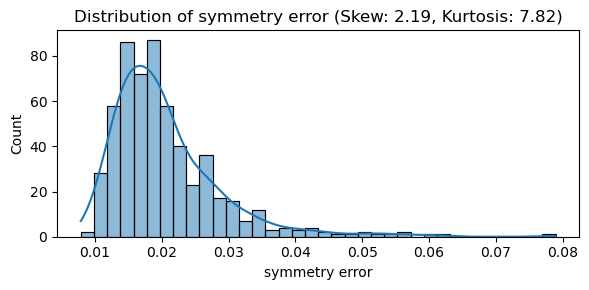

fractal dimension error | Skew: 3.91 | Kurtosis: 26.04


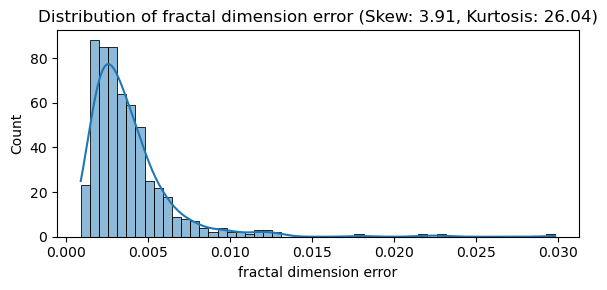

worst radius         | Skew: 1.10 | Kurtosis: 0.93


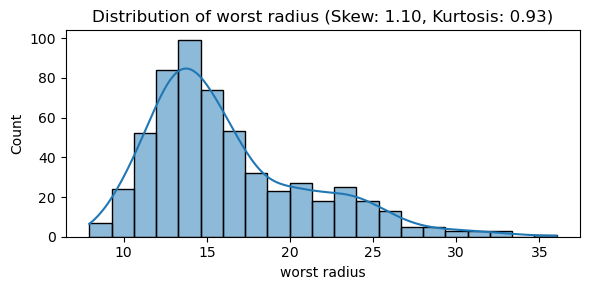

worst texture        | Skew: 0.50 | Kurtosis: 0.21


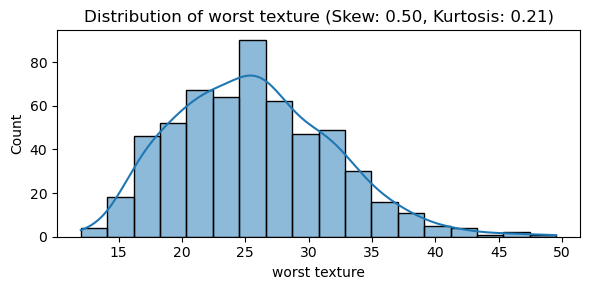

worst perimeter      | Skew: 1.13 | Kurtosis: 1.05


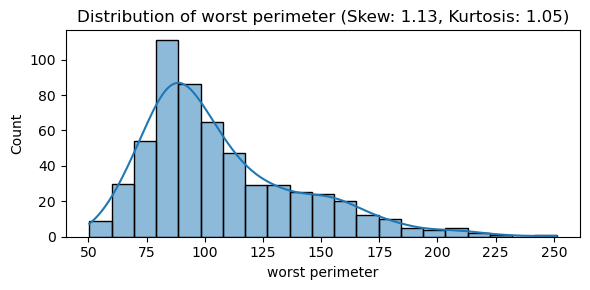

worst area           | Skew: 1.85 | Kurtosis: 4.35


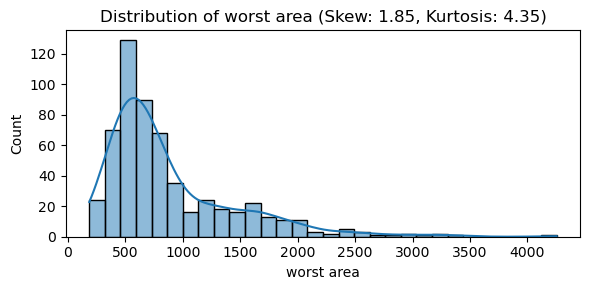

worst smoothness     | Skew: 0.41 | Kurtosis: 0.50


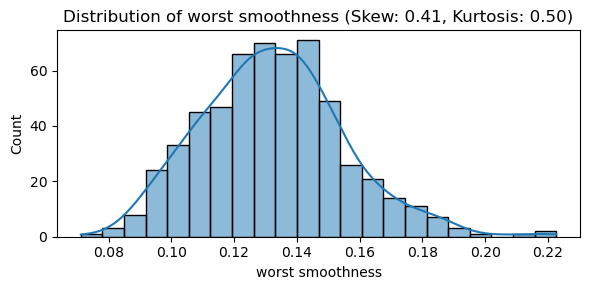

worst compactness    | Skew: 1.47 | Kurtosis: 3.00


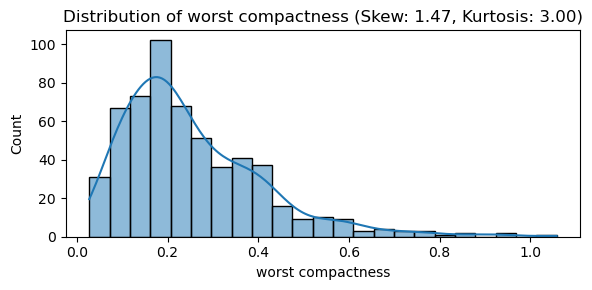

worst concavity      | Skew: 1.15 | Kurtosis: 1.59


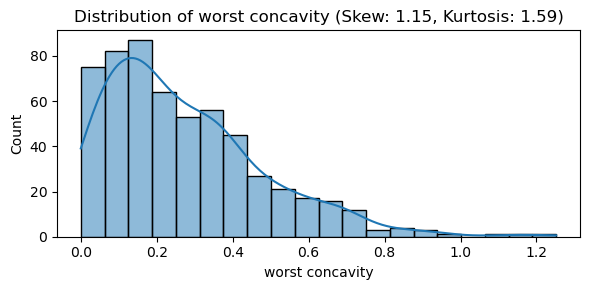

worst concave points | Skew: 0.49 | Kurtosis: -0.54


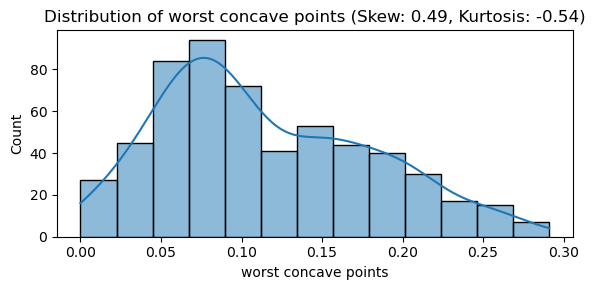

worst symmetry       | Skew: 1.43 | Kurtosis: 4.40


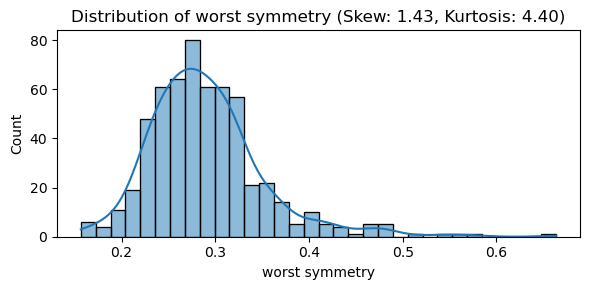

worst fractal dimension | Skew: 1.66 | Kurtosis: 5.19


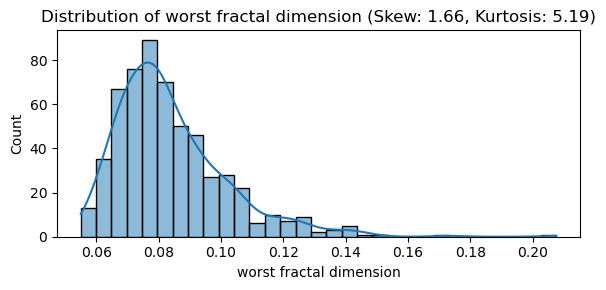


 Relationship with Target (charges):


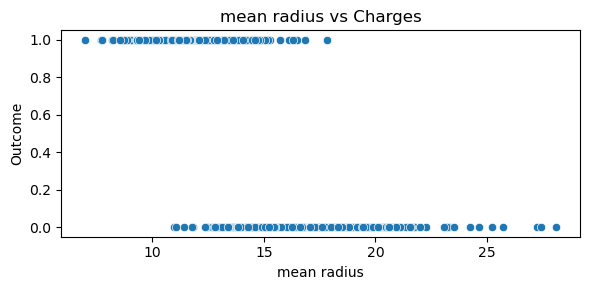

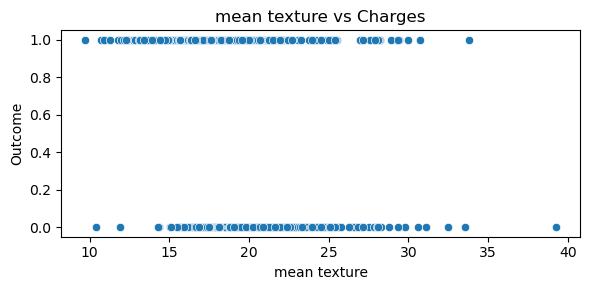

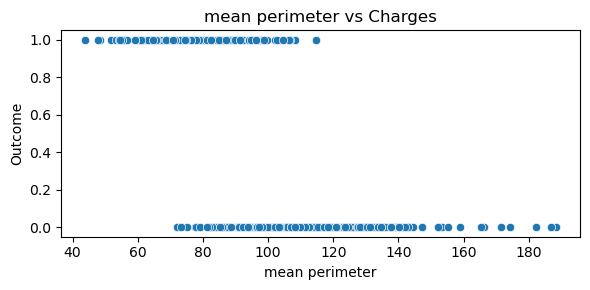

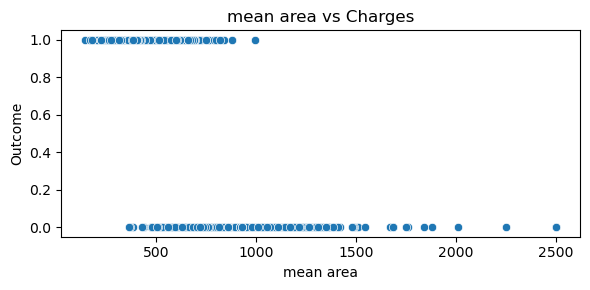

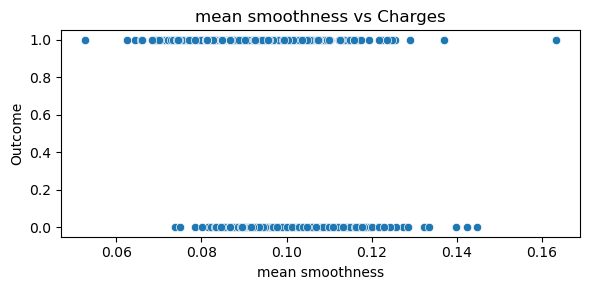

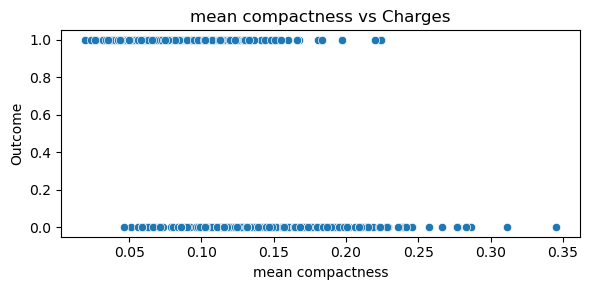

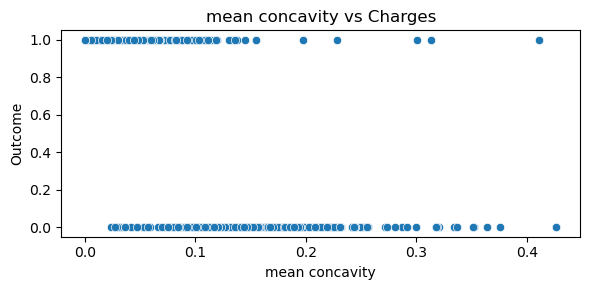

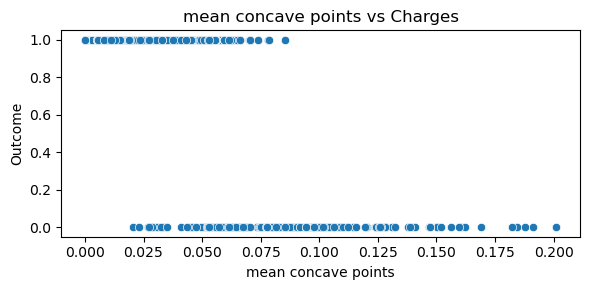

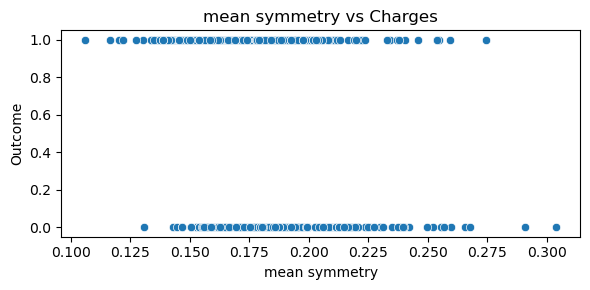

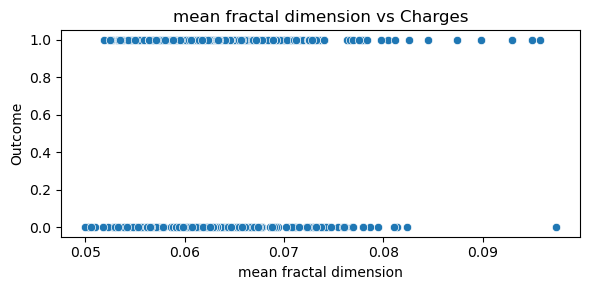

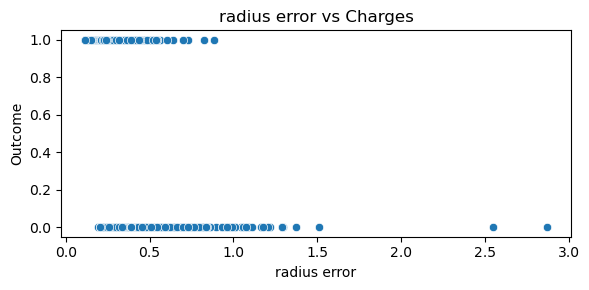

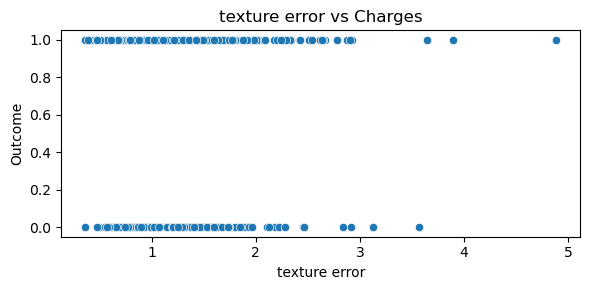

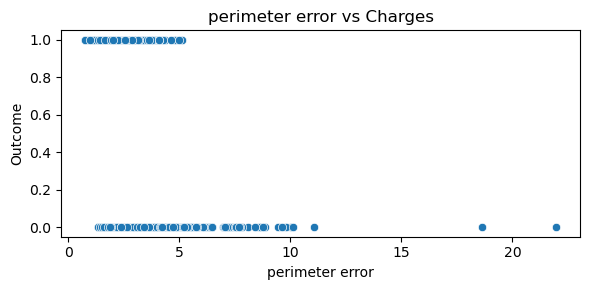

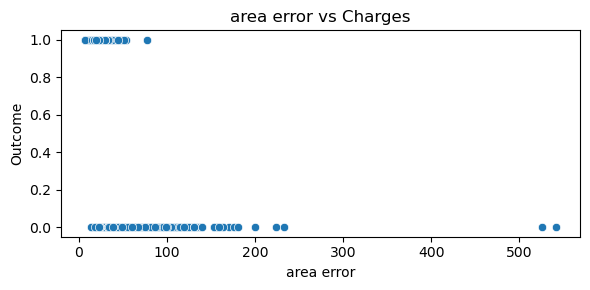

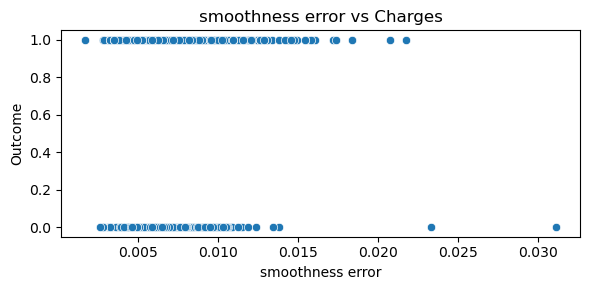

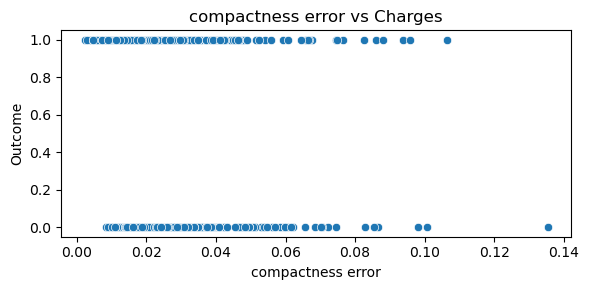

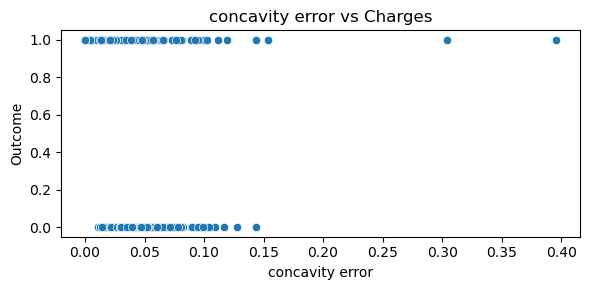

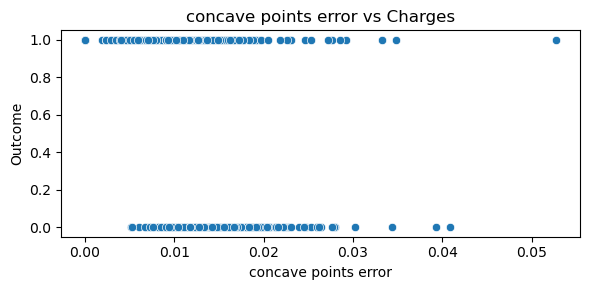

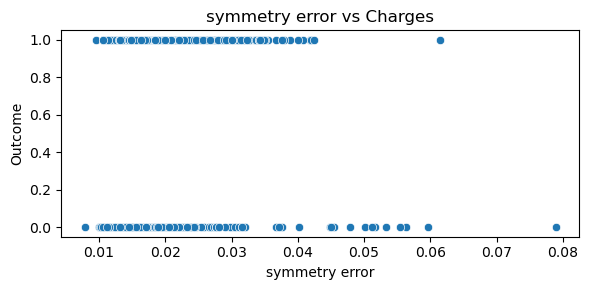

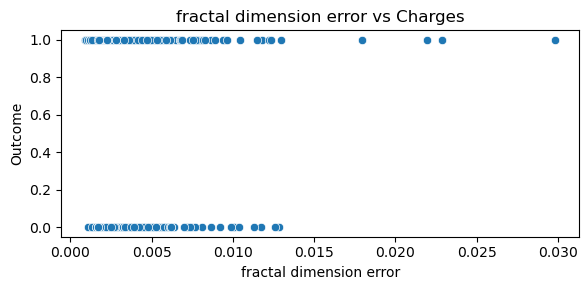

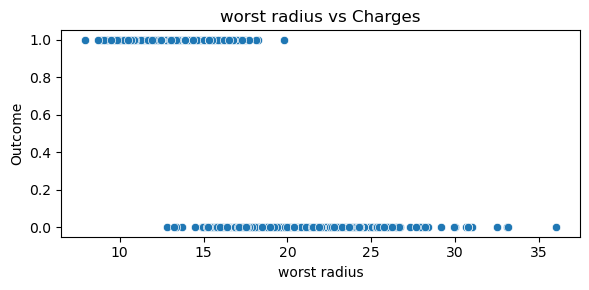

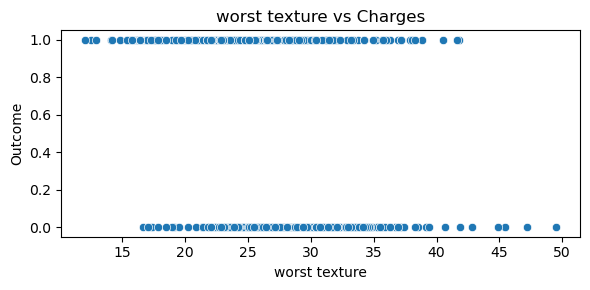

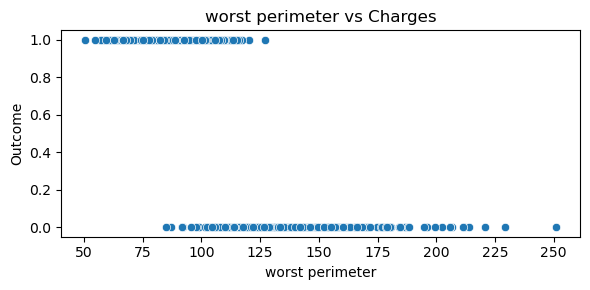

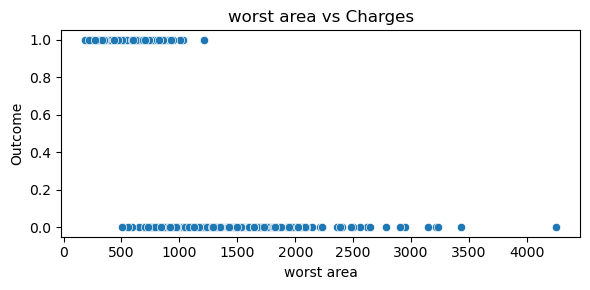

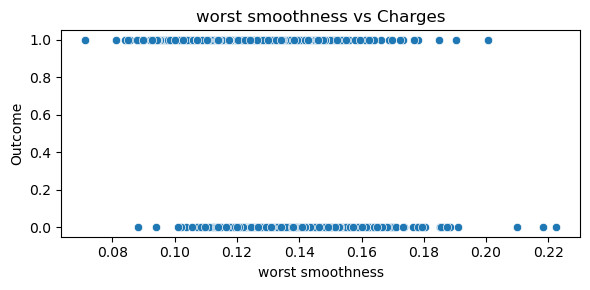

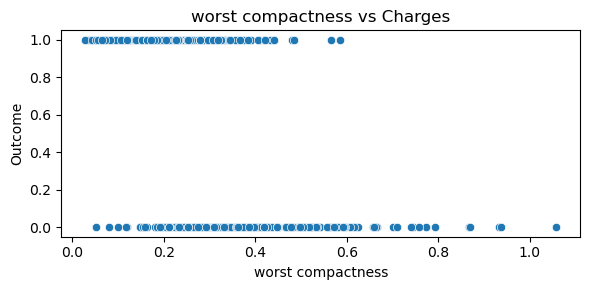

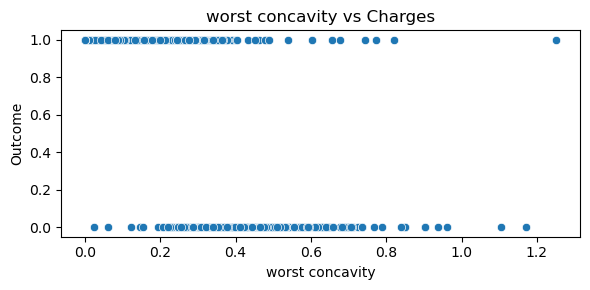

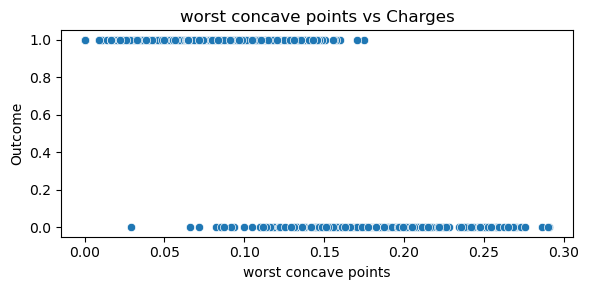

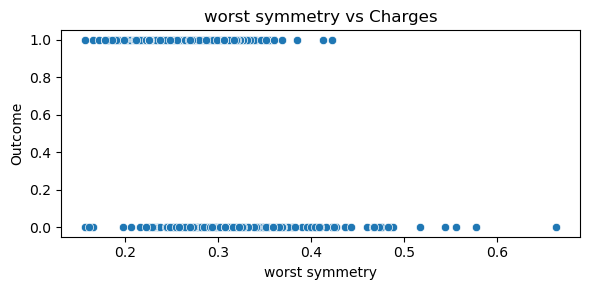

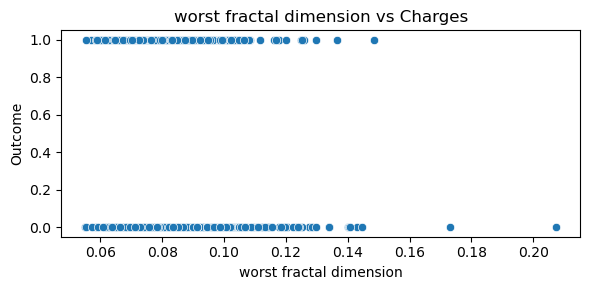

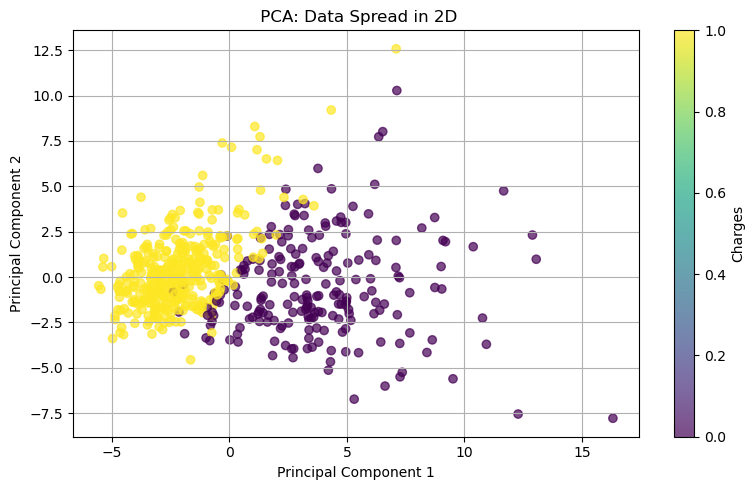

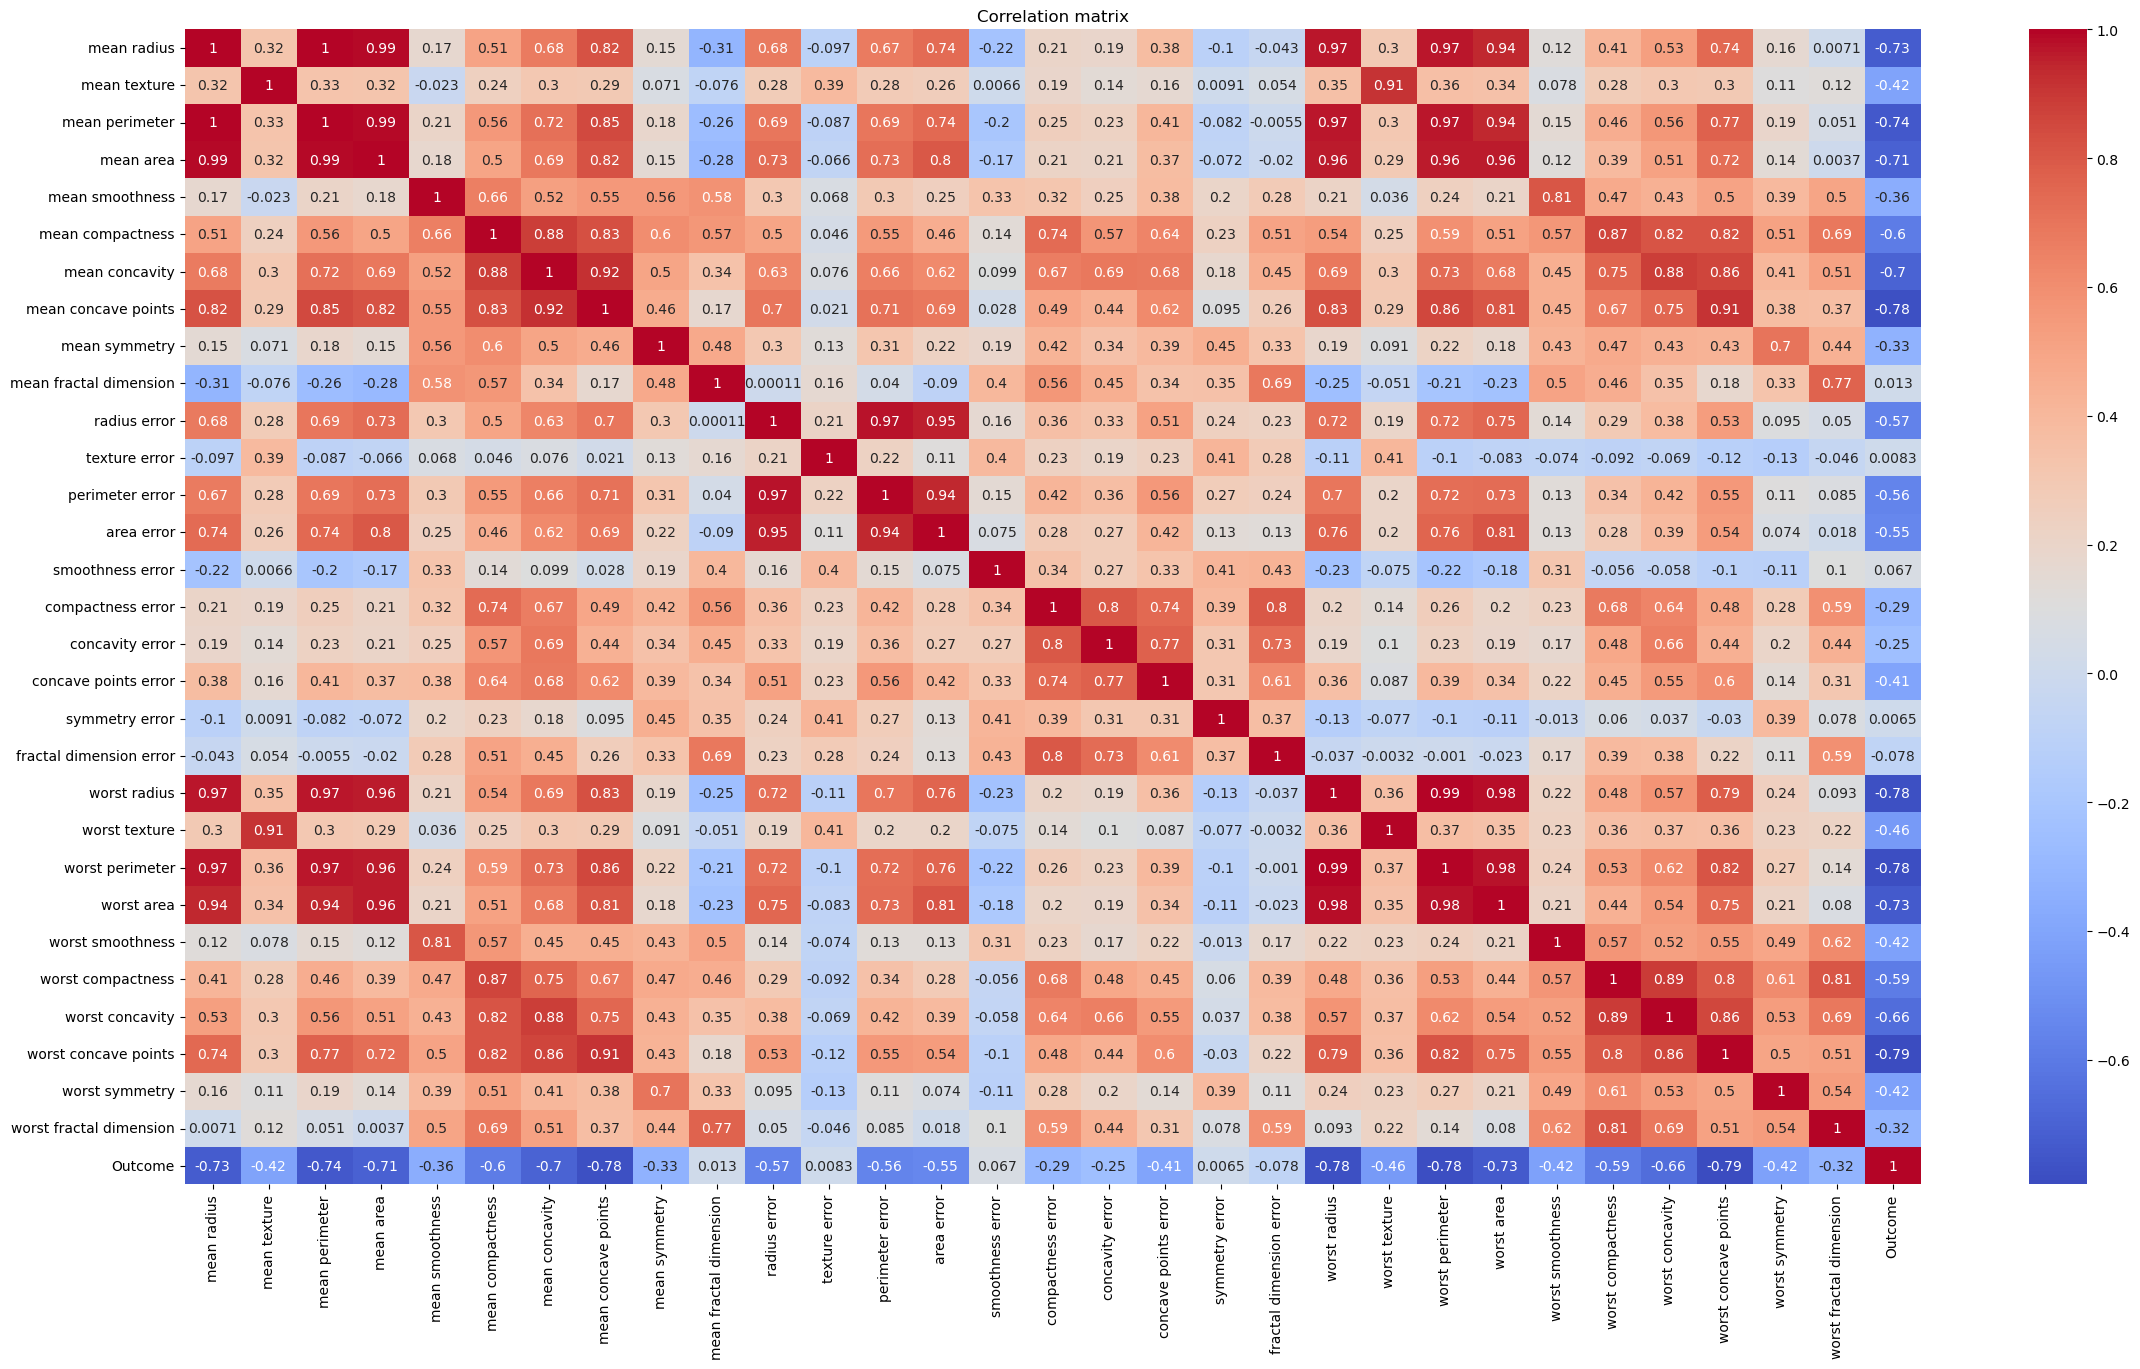

In [28]:
from sklearn.datasets import load_breast_cancer

# Load the dataset
data_raw = load_breast_cancer()
data = pd.DataFrame(data_raw.data, columns=data_raw.feature_names)
data['Outcome'] = data_raw.target  # 0 = malignant, 1 = benign

# (Optional) Clean data if needed
#data = clean_data(data, method='fill_mean')

print('\n-------------------------------------------------------------------\n')
print(data.info())
print('\n-------------------------------------------------------------------\n')
print(data.columns)

# Feature matrix and target
X = data.drop(columns=['Outcome'])
y = data['Outcome']

# Plot (assuming your function data_plot exists)
data_plot(data, X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=42)

# Add intercept term (bias)
X_train = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
X_test = np.hstack([np.ones((X_test.shape[0], 1)), X_test])


## **Simple Logistic regression**
- Calling logistic regression from `all_model.py` module(self code from scratch).
- Implement standard Logistic Regression using Maximum Likelihood Estimation (MLE).
- Use the sigmoid function to model the probability of class `1`.
- Optimize the log-likelihood using a gradient-based method (e.g., BFGS).
- Make predictions using a 0.5 threshold on the predicted probabilities.
- Evaluate model performance using **Accuracy**.



 Accuracy: 100.00%

 Confusion Matrix:
 [[169   0]
 [  0 286]]


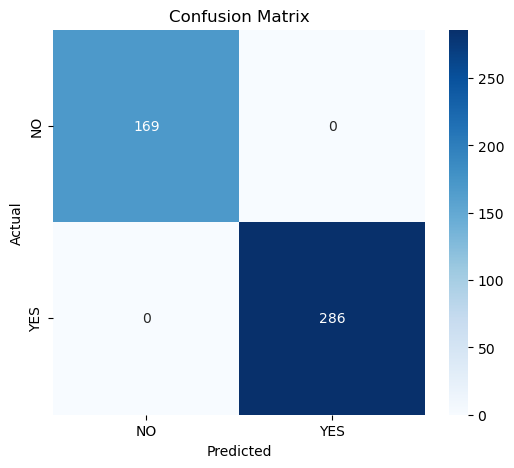

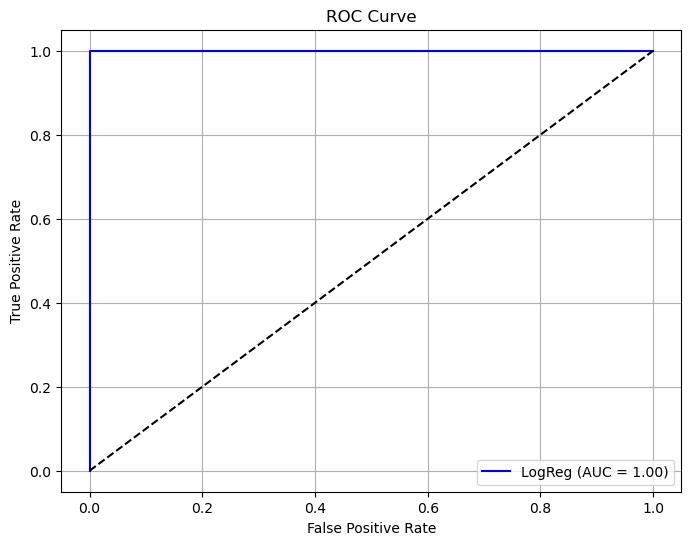


Test Accuracy: 94.74%

Test Confusion Matrix:
 [[42  1]
 [ 5 66]]


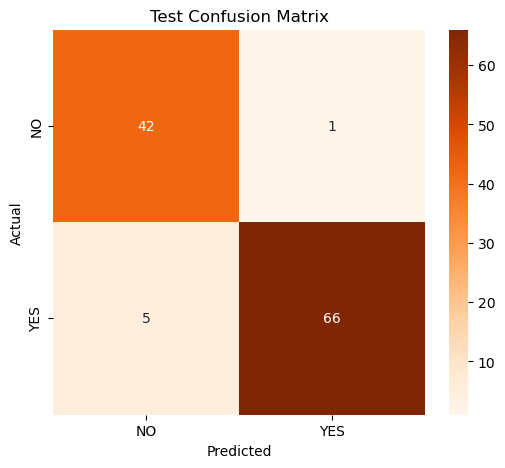

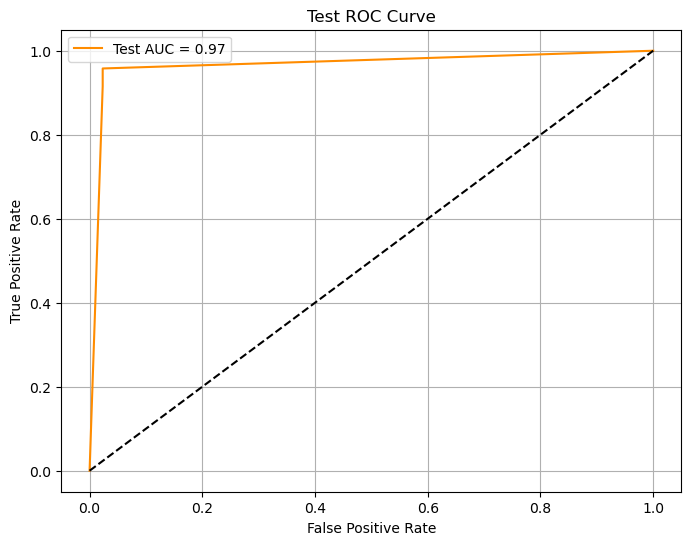

In [29]:
# Step 1: Call training function on training data
train_results = run_logistic_regression_analysis(X_train, y_train)

# Step 2: Call testing function on test data
test_results = test_logistic(train_results['coefficients'], X_test, y_test)


## **Bayesian Logistic Regression (BLR) Implementation and Evaluation**

This code implements and compares **three approximation methods** for Bayesian Logistic Regression:

* **Laplace Approximation**
* **Variational Inference** (Mean-field)
* **MCMC** (Metropolis-Hastings)

It also includes visualization tools like ROC curves, predictive distributions, and confusion matrices.

### **Core Concepts**

* Unlike traditional logistic regression which gives single weight estimates, **Bayesian Logistic Regression (BLR)** provides a **distribution** over weights.
* Since the logistic likelihood isn’t conjugate with the Gaussian prior, exact inference is not feasible.
* Hence, we use **approximation techniques** to infer the posterior over weights.


## **Model Evaluation Pipeline**

For each approximation method:

1. Compute approximate posterior (Laplace/VI) or draw samples (MCMC)
2. Predict probabilities: $\sigma(X w)$
3. Convert to binary using threshold 0.5
4. Evaluate:

   * Accuracy
   * ROC AUC
   * Log Loss
   * Confusion Matrix
   * Predictive uncertainty (mean & std of predictions)

## **1. Laplace Approximation**

### **Algorithm:**

1. Initialize weights $w = 0$.
2. Optimize the **Negative Log Posterior** using gradient-based optimization to get MAP estimate $w_{MAP}$.
3. Compute the **Hessian** of the negative log posterior at $w_{MAP}$:

   * $H = X^T S X + \alpha I$
   * where $S = \text{diag}(\sigma(z_i)(1 - \sigma(z_i)))$
4. Approximate posterior as:

   * Mean: $w_{MAP}$
   * Covariance: $H^{-1}$

## **2. Variational Inference (Mean-field)**

### **Algorithm:**

We approximate the posterior with a Gaussian $q(w) = \mathcal{N}(m, S)$, assuming a diagonal covariance matrix (mean-field assumption).

1. **Initialize**:

   * Mean $m = 0$
   * Covariance $S = I$

2. **Repeat until convergence**:

   * For each data point $x_i$:

     * Compute the soft evidence term:
       $L_i = \sqrt{x_i^T S x_i + (x_i^T m)^2}$
     * Compute local variational parameters:
       $\lambda_i = \frac{\tanh(L_i / 2)}{2L_i + \epsilon}$

   * Define diagonal matrix $\Lambda = \text{diag}(\lambda_1, ..., \lambda_n)$

   * Update covariance and mean:
     $S = \left(X^T \Lambda X + \alpha I \right)^{-1}$
     $m = S X^T (y - 0.5)$

3. **Check for convergence**:

   * Stop when change in $m$ is below a threshold:
     $\| m_{t+1} - m_t \|_{\infty} < \epsilon$

This algorithm approximates the posterior with a Gaussian that closely mimics the true posterior and is fast and scalable.



## **3. MCMC Sampling (Metropolis-Hastings)**

### **Algorithm:**

1. **Initialize** weights $w_0 = 0$
2. For each iteration:

   * Sample proposal $w^* \sim \mathcal{N}(w_t, \Sigma)$
   * Compute acceptance ratio:
     $\alpha = \min\left(1, \frac{p(w^*|X,y)}{p(w_t|X,y)} \right)$
   * Accept proposal with probability $\alpha$; otherwise, keep current sample
3. After a burn-in period, collect remaining samples as posterior draws
4. Estimate predictions using the posterior predictive distribution:

   * Sample weights $w$ from posterior
   * Compute predictions $\sigma(X w)$ for each sample

Note: Tuning the proposal distribution (covariance/scale) is critical. In our run, MCMC had **0.00 acceptance rate**, which indicates poor proposal design.



## **Visualization Tools**

* **ROC Curve**: Shows model’s performance across thresholds
* **Predictive Distribution**: Visualizes probability estimates per class
* **Confusion Matrix**: Confirms prediction/classification accuracy
* **Weight Distributions (MCMC)**: Displays uncertainty in parameters


## **Comparison Table**

| Method          | Train Acc | Test Acc | Train AUC | Test AUC | Test Log Loss |
| --------------- | --------- | -------- | --------- | -------- | ------------- | 
| **Laplace**     | 0.9582    | 0.9561   | 0.9941    | 0.9977   | 0.0804        |
| **Variational** | 0.9582    | 0.9561   | 0.9940    | 0.9977   | 0.0772        |
| **MCMC**        | 0.9011    | 0.9298   | 0.9730    | 0.9905   | 0.1523        | 


### **Which One is Better?**

* **Laplace Approximation** is fast and good for small or moderately complex datasets where Gaussian approximation of posterior is reasonable.
* **Variational Inference** is scalable to large datasets and balances speed with moderate posterior accuracy.
* **MCMC** is the gold standard for posterior estimation and uncertainty but is computationally heavy and requires good tuning.

**Conclusion:** For fast and effective approximation, use **Variational Inference**. For precise uncertainty and scientific analysis, use **MCMC** (with proper tuning). Use **Laplace** for analytical ease and baseline comparison.


## **Summary**

This modular Bayesian logistic regression framework demonstrates how different approximation techniques affect model behavior and uncertainty quantification.

### Use:

* **Laplace Approximation** for quick and reasonable approximation when posterior is close to Gaussian
* **Variational Inference** for scalable and stable performance, especially on large datasets
* **MCMC** when detailed posterior uncertainty is essential — provided the sampler is well-tuned


Class distribution in training set: [169 286]
Class distribution in test set: [43 71]

=== Evaluating LAPLACE approximation ===
Train Accuracy: 0.9604
Test Accuracy: 0.9561
Train AUC: 0.9941
Test AUC: 0.9977
Test Log Loss: 0.0806


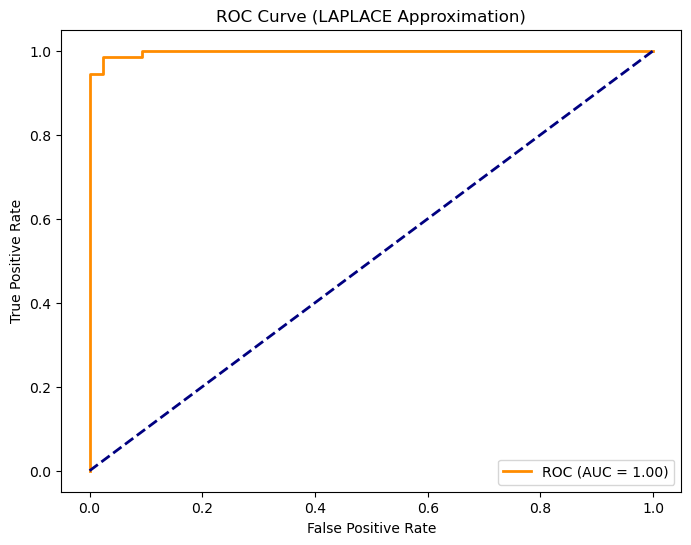

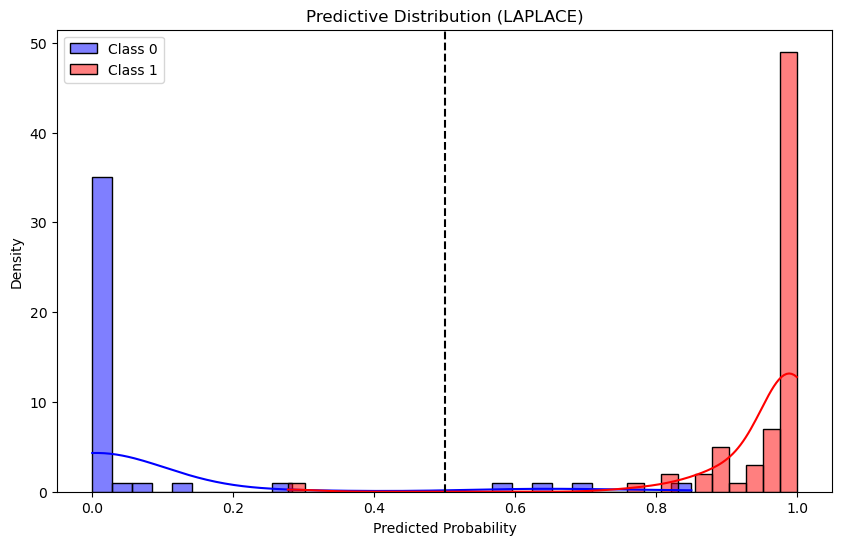

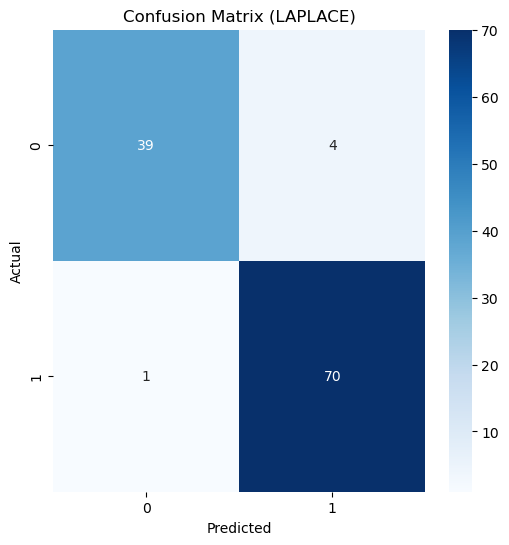


=== Evaluating VARIATIONAL approximation ===
Train Accuracy: 0.9582
Test Accuracy: 0.9561
Train AUC: 0.9940
Test AUC: 0.9977
Test Log Loss: 0.0773


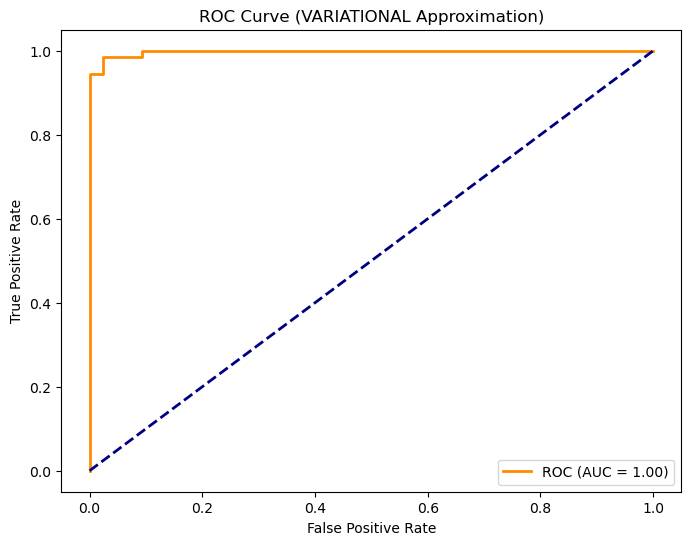

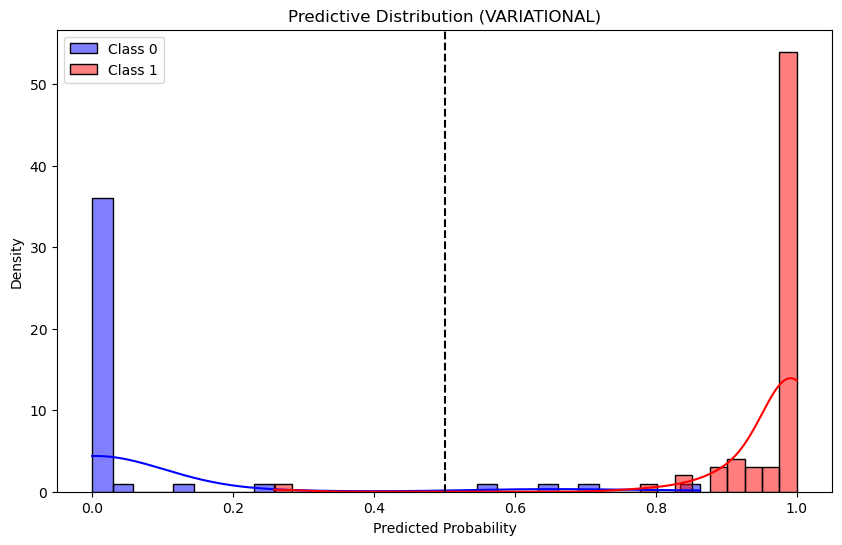

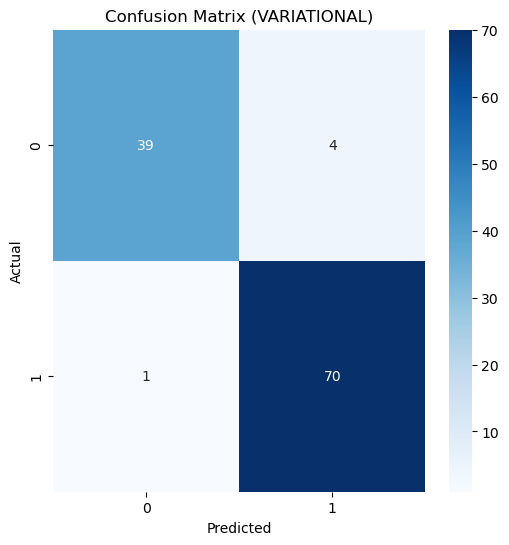


=== Evaluating MCMC approximation ===
Acceptance rate: 0.00
Train Accuracy: 0.9077
Test Accuracy: 0.9211
Train AUC: 0.9484
Test AUC: 0.9869
Test Log Loss: 0.1361


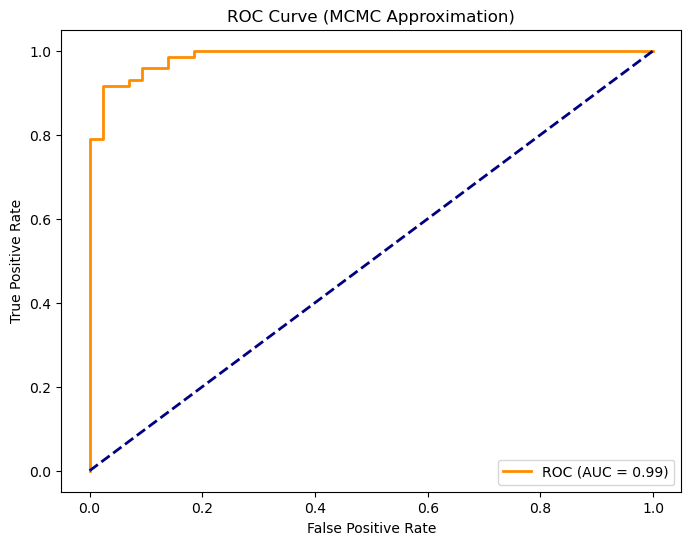

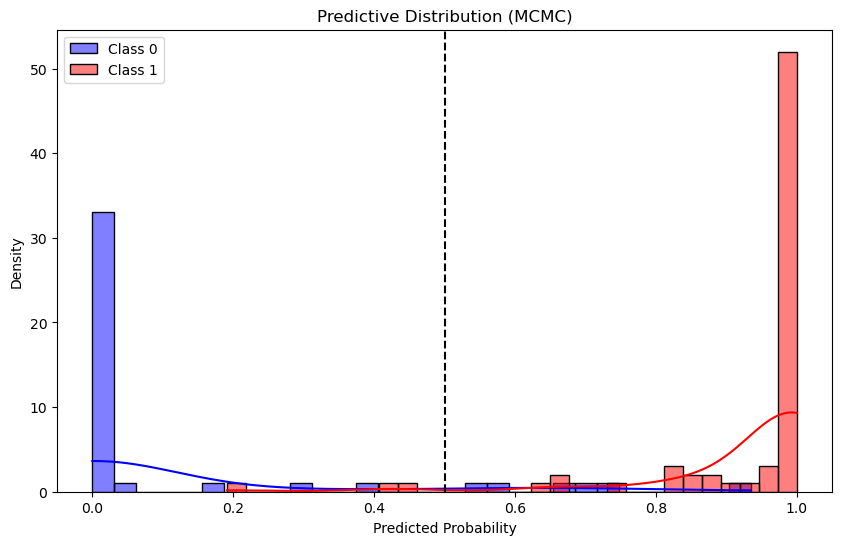

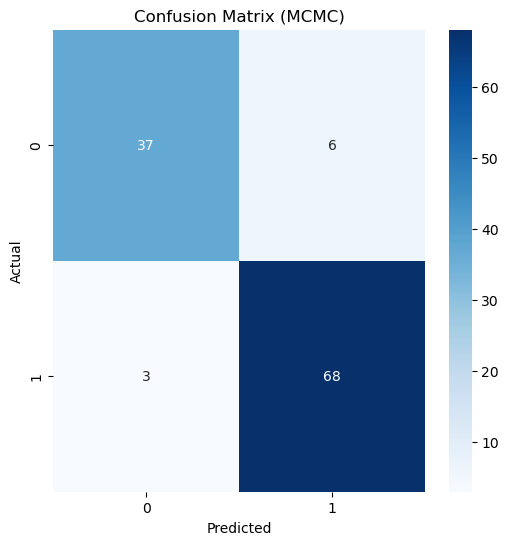

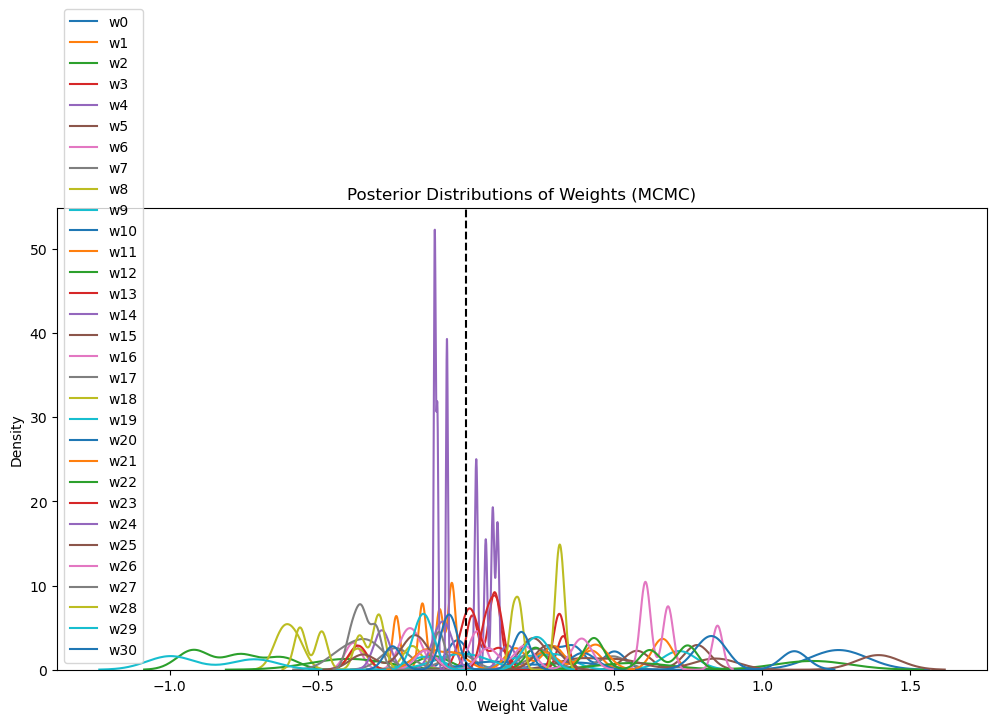

In [30]:

def sigmoid(z):
    z = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z))

def add_intercept(X):
    return np.hstack([np.ones((X.shape[0], 1)), X])

def log_likelihood(w, X, y):
    """Compute log likelihood of data given parameters"""
    z = X @ w
    # More numerically stable version
    ll = np.sum(y * z - np.log1p(np.exp(z)))
    return ll

def log_prior(w, prior_mean, prior_cov):
    """Compute log prior probability of parameters"""
    return multivariate_normal.logpdf(w, mean=prior_mean, cov=prior_cov)

def log_posterior(w, X, y, prior_mean, prior_cov):
    """Compute unnormalized log posterior"""
    return log_likelihood(w, X, y) + log_prior(w, prior_mean, prior_cov)

def neg_log_posterior(w, X, y, alpha=1.0):
    """Negative log posterior for logistic regression with L2 prior"""
    z = X @ w
    p = sigmoid(z)
    log_lik = np.sum(y * np.log(p + 1e-15) + (1-y) * np.log(1-p + 1e-15))
    log_prior = -0.5 * alpha * np.sum(w**2)
    return -(log_lik + log_prior)

def grad_neg_log_posterior(w, X, y, alpha=1.0):
    z = X @ w
    p = sigmoid(z)
    grad = X.T @ (p - y) + alpha * w
    return grad

# ------------------------------
# Main Approximation Methods
# ------------------------------

def laplace_approximation(X_train, y_train, alpha=1.0):
    """
    Laplace approximation for Bayesian logistic regression
    Returns the MAP estimate and covariance matrix of the approximation
    """
    # Ensure y_train is 1D array
    y_train = np.squeeze(y_train)
    
    init_w = np.zeros(X_train.shape[1])
    result = minimize(neg_log_posterior, init_w, args=(X_train, y_train, alpha),
                     jac=grad_neg_log_posterior, method='L-BFGS-B')
    
    w_map = result.x
    
    # Compute Hessian at MAP for covariance approximation
    z = X_train @ w_map
    p = sigmoid(z)
    S = np.diag(p * (1 - p))
    H = X_train.T @ S @ X_train + alpha * np.eye(X_train.shape[1])
    cov = np.linalg.inv(H)
    
    return w_map, cov

def variational_inference(X_train, y_train, alpha=1.0, max_iter=1000, tol=1e-4):
    """
    Mean-field variational inference for Bayesian logistic regression
    Returns the approximate posterior mean and covariance
    """
    # Ensure y_train is 1D array
    y_train = np.squeeze(y_train)
    
    n, d = X_train.shape
    m = np.zeros(d)
    S = np.eye(d)
    L = np.zeros(n)
    
    for iteration in range(max_iter):
        # Update variational parameters
        L = np.sqrt(np.sum((X_train @ S) * X_train, axis=1) + np.sum(X_train * m, axis=1)**2)
        lam = np.tanh(L / 2) / (2 * L + 1e-8)
        
        # Update Gaussian parameters
        S = np.linalg.inv(X_train.T @ (lam[:, None] * X_train) + alpha * np.eye(d))
        m = S @ (X_train.T @ (y_train - 0.5))
        
        # Check convergence
        if iteration > 0 and np.max(np.abs(m - m_prev)) < tol:
            break
        m_prev = m.copy()
    
    return m, S

def mcmc_sampling(X_train, y_train, n_samples=5000, burn_in=1000, 
                 prior_mean=None, prior_cov=None, proposal_scale=0.1):
    """
    MCMC sampling for Bayesian logistic regression using Metropolis-Hastings
    Returns posterior samples
    """
    # Ensure y_train is 1D array
    y_train = np.squeeze(y_train)
    
    n, p = X_train.shape
    
    # Set default priors if not specified
    if prior_mean is None:
        prior_mean = np.zeros(p)
    if prior_cov is None:
        prior_cov = np.eye(p) * 10  # Weakly informative prior
    
    # Initialize parameters
    w_current = np.zeros(p)
    samples = np.zeros((n_samples, p))
    accepted = 0
    
    # Proposal distribution covariance
    proposal_cov = np.eye(p) * proposal_scale
    
    # Current log posterior
    current_log_post = log_posterior(w_current, X_train, y_train, prior_mean, prior_cov)
    
    for i in range(n_samples + burn_in):
        # Propose new parameters
        w_proposed = multivariate_normal.rvs(mean=w_current, cov=proposal_cov)
        
        # Calculate log posterior for proposed parameters
        proposed_log_post = log_posterior(w_proposed, X_train, y_train, prior_mean, prior_cov)
        
        # Acceptance ratio
        log_accept_ratio = proposed_log_post - current_log_post
        
        # Accept or reject
        if np.log(np.random.rand()) < log_accept_ratio:
            w_current = w_proposed
            current_log_post = proposed_log_post
            if i >= burn_in:
                accepted += 1
        
        # Store sample after burn-in
        if i >= burn_in:
            samples[i - burn_in] = w_current
    
    acceptance_rate = accepted / n_samples
    print(f"Acceptance rate: {acceptance_rate:.2f}")
    
    return samples

# Evaluation Function

def evaluate_bayesian_model(X_train, y_train, X_test, y_test, method='laplace', **kwargs):
    """
    Evaluate Bayesian logistic regression with specified approximation method
    Supported methods: 'laplace', 'variational', 'mcmc'
    """
    # Ensure y_train and y_test are 1D arrays
    y_train = np.squeeze(y_train)
    y_test = np.squeeze(y_test)
    
    # Check for single-class case
    if len(np.unique(y_train)) < 2:
        print("Warning: Only one class present in training data")
        # Return dummy metrics
        n_train = len(y_train)
        n_test = len(y_test)
        return {
            'train_accuracy': accuracy_score(y_train, np.ones(n_train)),
            'test_accuracy': accuracy_score(y_test, np.ones(n_test)),
            'train_log_loss': 0.0,
            'test_log_loss': 0.0,
            'train_auc': 1.0,
            'test_auc': 1.0,
            'confusion_matrix': confusion_matrix(y_test, np.ones(n_test)),
            'proba_mean_train': np.ones(n_train),
            'proba_std_train': np.zeros(n_train),
            'proba_mean_test': np.ones(n_test),
            'proba_std_test': np.zeros(n_test),
            'w_mean': np.zeros(X_train.shape[1]),
            'samples': None
        }
    
    if method == 'laplace':
        # Laplace approximation
        w_mean, w_cov = laplace_approximation(X_train, y_train, **kwargs)
        
        # Predict using the MAP estimate
        proba_train = sigmoid(X_train @ w_mean)
        proba_test = sigmoid(X_test @ w_mean)
        
        # For uncertainty estimation, sample from approximate posterior
        samples = multivariate_normal.rvs(mean=w_mean, cov=w_cov, size=1000)
        proba_samples_train = sigmoid(X_train @ samples.T)
        proba_samples_test = sigmoid(X_test @ samples.T)
        
        # Compute mean and std of predictions
        proba_mean_train = np.mean(proba_samples_train, axis=1)
        proba_std_train = np.std(proba_samples_train, axis=1)
        proba_mean_test = np.mean(proba_samples_test, axis=1)
        proba_std_test = np.std(proba_samples_test, axis=1)
        
    elif method == 'variational':
        # Variational inference
        w_mean, w_cov = variational_inference(X_train, y_train, **kwargs)
        
        # Predict using the variational mean
        proba_train = sigmoid(X_train @ w_mean)
        proba_test = sigmoid(X_test @ w_mean)
        
        # Sample from variational distribution
        samples = multivariate_normal.rvs(mean=w_mean, cov=w_cov, size=1000)
        proba_samples_train = sigmoid(X_train @ samples.T)
        proba_samples_test = sigmoid(X_test @ samples.T)
        
        proba_mean_train = np.mean(proba_samples_train, axis=1)
        proba_std_train = np.std(proba_samples_train, axis=1)
        proba_mean_test = np.mean(proba_samples_test, axis=1)
        proba_std_test = np.std(proba_samples_test, axis=1)
        
    elif method == 'mcmc':
        # MCMC sampling
        samples = mcmc_sampling(X_train, y_train, **kwargs)
        
        # Predict using all posterior samples
        proba_samples_train = sigmoid(X_train @ samples.T)
        proba_samples_test = sigmoid(X_test @ samples.T)
        
        proba_mean_train = np.mean(proba_samples_train, axis=1)
        proba_std_train = np.std(proba_samples_train, axis=1)
        proba_mean_test = np.mean(proba_samples_test, axis=1)
        proba_std_test = np.std(proba_samples_test, axis=1)
        
        # For point estimates, use the posterior mean
        w_mean = np.mean(samples, axis=0)
        proba_train = proba_mean_train
        proba_test = proba_mean_test
    else:
        raise ValueError("Method must be 'laplace', 'variational', or 'mcmc'")
    
    # Make predictions
    pred_train = (proba_mean_train >= 0.5).astype(int)
    pred_test = (proba_mean_test >= 0.5).astype(int)
    
    # Calculate metrics
    metrics = {
        'train_accuracy': accuracy_score(y_train, pred_train),
        'test_accuracy': accuracy_score(y_test, pred_test),
        'train_log_loss': log_loss(y_train, proba_mean_train),
        'test_log_loss': log_loss(y_test, proba_mean_test),
        'train_auc': roc_auc_score(y_train, proba_mean_train),
        'test_auc': roc_auc_score(y_test, proba_mean_test),
        'confusion_matrix': confusion_matrix(y_test, pred_test),
        'proba_mean_train': proba_mean_train,
        'proba_std_train': proba_std_train,
        'proba_mean_test': proba_mean_test,
        'proba_std_test': proba_std_test,
        'w_mean': w_mean,
        'samples': samples if method == 'mcmc' else None
    }
    
    return metrics

# Visualization Functions


def plot_roc_curve(y_true, y_proba, title='ROC Curve'):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend()
    plt.show()

def plot_predictive_distribution(y_proba, y_true=None, title='Predictive Distribution'):
    plt.figure(figsize=(10, 6))
    if y_true is not None:
        sns.histplot(y_proba[y_true == 0], bins=30, kde=True, label='Class 0', color='blue', alpha=0.5)
        sns.histplot(y_proba[y_true == 1], bins=30, kde=True, label='Class 1', color='red', alpha=0.5)
    else:
        sns.histplot(y_proba, bins=30, kde=True, label='Predictions')
    plt.axvline(0.5, color='black', linestyle='--')
    plt.title(title)
    plt.xlabel('Predicted Probability')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

def plot_confusion_matrix(cm, title='Confusion Matrix'):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()



if __name__ == "__main__":
    
    # Check class distribution
    print("Class distribution in training set:", np.bincount(y_train.astype(int)))
    print("Class distribution in test set:", np.bincount(y_test.astype(int)))
    
    # Evaluate different methods
    methods = ['laplace', 'variational', 'mcmc']
    
    for method in methods:
        print(f"\n=== Evaluating {method.upper()} approximation ===")
        metrics = evaluate_bayesian_model(X_train, y_train, X_test, y_test, 
                                        method=method)
        
        print(f"Train Accuracy: {metrics['train_accuracy']:.4f}")
        print(f"Test Accuracy: {metrics['test_accuracy']:.4f}")
        print(f"Train AUC: {metrics['train_auc']:.4f}")
        print(f"Test AUC: {metrics['test_auc']:.4f}")
        print(f"Test Log Loss: {metrics['test_log_loss']:.4f}")
        
        # Plot ROC curve
        plot_roc_curve(y_test, metrics['proba_mean_test'], 
                      title=f'ROC Curve ({method.upper()} Approximation)')
        
        # Plot predictive distribution
        plot_predictive_distribution(metrics['proba_mean_test'], y_test,
                                   title=f'Predictive Distribution ({method.upper()})')
        
        # Plot confusion matrix
        plot_confusion_matrix(metrics['confusion_matrix'],
                            title=f'Confusion Matrix ({method.upper()})')
        
        # Plot parameter uncertainty if MCMC
        if method == 'mcmc' and metrics['samples'] is not None:
            plt.figure(figsize=(12, 6))
            for i in range(metrics['samples'].shape[1]):
                sns.kdeplot(metrics['samples'][:, i], label=f'w{i}')
            plt.axvline(0, color='black', linestyle='--')
            plt.title('Posterior Distributions of Weights (MCMC)')
            plt.xlabel('Weight Value')
            plt.ylabel('Density')
            plt.legend()
            plt.show()

## **Conclusion: Bayesian Summary**

In this notebook, we explored and compared **classical models** (OLS and Logistic Regression) with their **Bayesian counterparts** (Bayesian Linear Regression and Bayesian Logistic Regression), applying them on both regression and classification problems.


### **Bayesian Linear Regression (BLR)** vs **OLS**
- **OLS** provides point estimates for parameters (fixed $\beta$).
- **BLR** treats weights as distributions and gives **uncertainty estimates** via posterior:
  - Posterior mean: $w_{\text{post}}$
  - Posterior covariance: $\Sigma_{\text{post}}$
- **BLR is preferred** when:
  - You want credible intervals around predictions.
  - Data is limited or noisy.
- Visualization included uncertainty bands showing how model confidence varies across inputs.


### **Bayesian Logistic Regression (BLR)** vs **Logistic Regression**
- In classification, we studied three Bayesian approximation techniques:
  1. **Laplace Approximation** — Approximates posterior as Gaussian at MAP.
  2. **Variational Inference (VI)** — Optimizes a simple distribution (like Gaussian) to match true posterior.
  3. **MCMC (Metropolis-Hastings)** — Samples from the true posterior distribution directly.
  
- All three methods were wrapped and evaluated via:
  - Predictive probabilities
  - Accuracy, Log Loss, and ROC-AUC
  - Distribution plots of uncertainty

- **MCMC** gave the most realistic uncertainty estimates, but was slow.
- **VI** was computationally efficient, suitable for larger datasets.
- **Laplace** worked well near the MAP but might underestimate uncertainty.


###  Final Remarks:
- Bayesian approaches provide a **more honest estimate** of model confidence.



# **KNN**

Accuracy: 85.41%


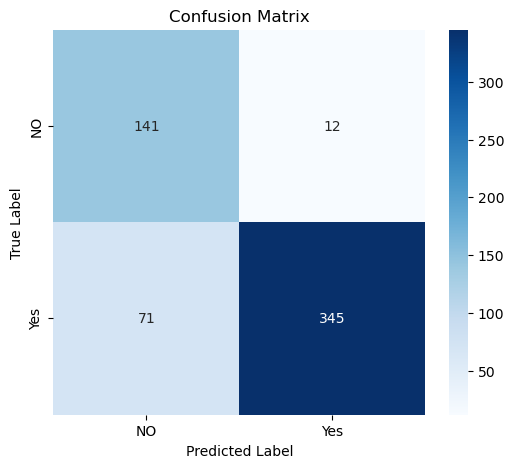

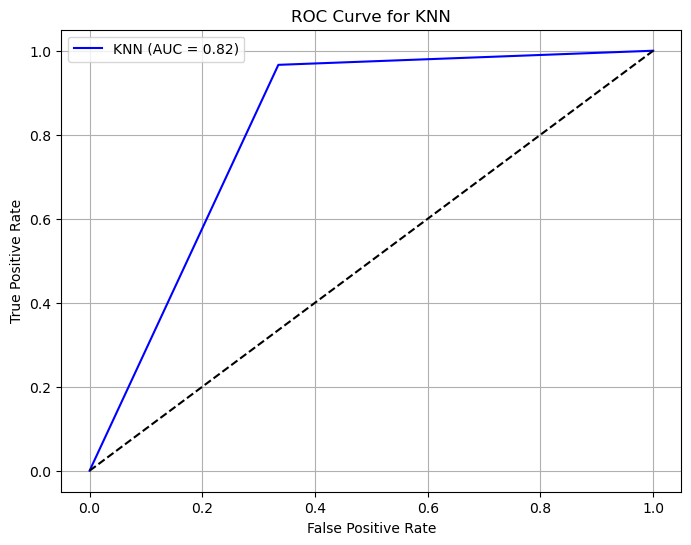

In [31]:



from collections import Counter
import numpy as np
from sklearn.metrics import accuracy_score

x = X.values
y = y.values
k = 12
y_predict = []

for i in range(len(x)):
    x0 = x[i]  # test point

    # Remove current point from x and y for leave-one-out validation
    x_temp = np.delete(x, i, axis=0)
    

    # Distance from x0 to all other points
    d = np.linalg.norm(x_temp - x0, axis = 1)

    # Find k-nearest neighbors
    nearest_neighbors = np.argsort(d)[:k]

    # Get their labels
    majority_vote = Counter(y[nearest_neighbors]).most_common(1)[0][0]
    x_temp = np.append(x_temp, x0)
    y_predict.append(majority_vote)

# Accuracy
accr = accuracy_score(y, y_predict)
print(f"Accuracy: {accr*100:.2f}%")

#Confusion matrix 
confs_mtx = confusion_matrix(y_predict, y)
y_pre8 = y_predict

#ploting of confusion matrix
# Define class labels
labels = ['NO', 'Yes']  # Replace with your actual class names if needed

# Plot the heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(confs_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, thresholds = roc_curve(y, y_predict)
auc_score = auc(fpr, tpr)

# 6. Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='KNN (AUC = %.2f)' % auc_score, color='blue')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for KNN')
plt.legend()
plt.grid(True)
plt.show()